# **SME5924 - Processos Dinâmicos em Redes Complexas**


---


## **Questionário 5**

### Gabriela dos Santos Amaral

# **Introdução**

Notebook contendo os códigos desenvolvidos na linguagem *Python* para responder o questionário 5 da disciplina de Processos Dinâmicos em Redes Complexas (SME5924).

## **Enunciado**

### **Classificação de redes complexas**

Selecione 3 redes biológicas, 3 redes sociais e 3 redes tecnológicas nesses endereços:
* https://networks.skewed.de
* http://konect.cc/networks/
* https://icon.colorado.edu/

Faça a classificação das redes selecionadas usando os modelos e medidas que
aprendemos na aula (grafos aleatórios, small-world, Barabási-Albert, Waxman, etc).

Não se esqueça de selecionar o mesmo N e grau médio que a rede original na
construção dos modelos.

Verifique qual o modelo mais adequado para cada rede.

> *Hipótese: redes do mesmo tipo (biológica, social e tecnológica) seguem o mesmo modelo.*

Verifique se essa hipótese é verdadeira.
Use um método de classificação que achar adequada. Faça a projeção dos dados
usando PCA. Ou seja, obtenha algo assim:

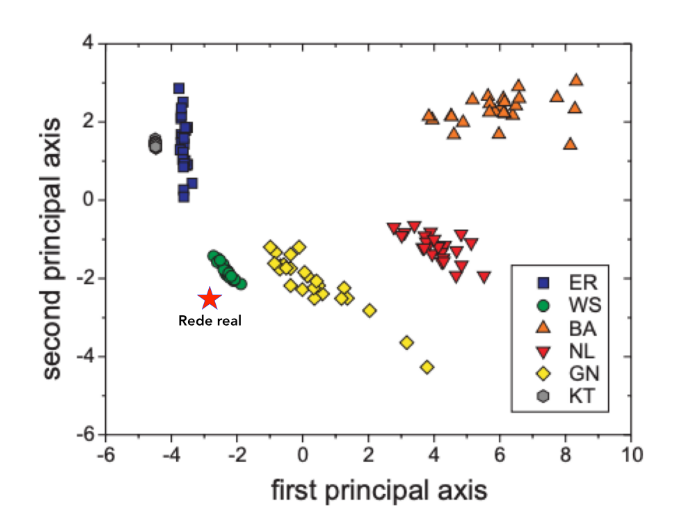

# **Desenvolvimento | Códigos**

## **Instalando graph-tool** (https://graph-tool.skewed.de)
* Forma 1: https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=jmRYQDL161hB
* Forma 2: https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt-git.ipynb#scrollTo=ccAj89hUOqoU

### Forma 1

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [2]:
!mamba install -q graph-tool

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 


done


### Forma 2

In [ ]:
# !add-apt-repository -y "deb [trusted=yes] http://downloads.skewed.de/apt-git $(lsb_release -s -c) main"
# !apt-get update
# !apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
# # Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
# !apt purge python3-cairo
# !apt install libcairo2-dev pkg-config python3-dev
# !pip install --force-reinstall pycairo
# !pip install zstandard

## **Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import requests

import random
import math
import plotly.express as px

from graph_tool.all import *
import graph_tool.all as gt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# from networkx.algorithms.community import greedy_modularity_communities
# from community import community_louvain

## **Redes Biológicas**

### Rede Biológica 1: Macaque cortical connectivity

* Uma rede de regiões corticais no córtex de um macaco.
* Fonte: https://networks.skewed.de/net/macaque_neural#None_draw


In [2]:
g = gt.collection.ns["macaque_neural"]

In [3]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [4]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 47
Número de arestas: 313


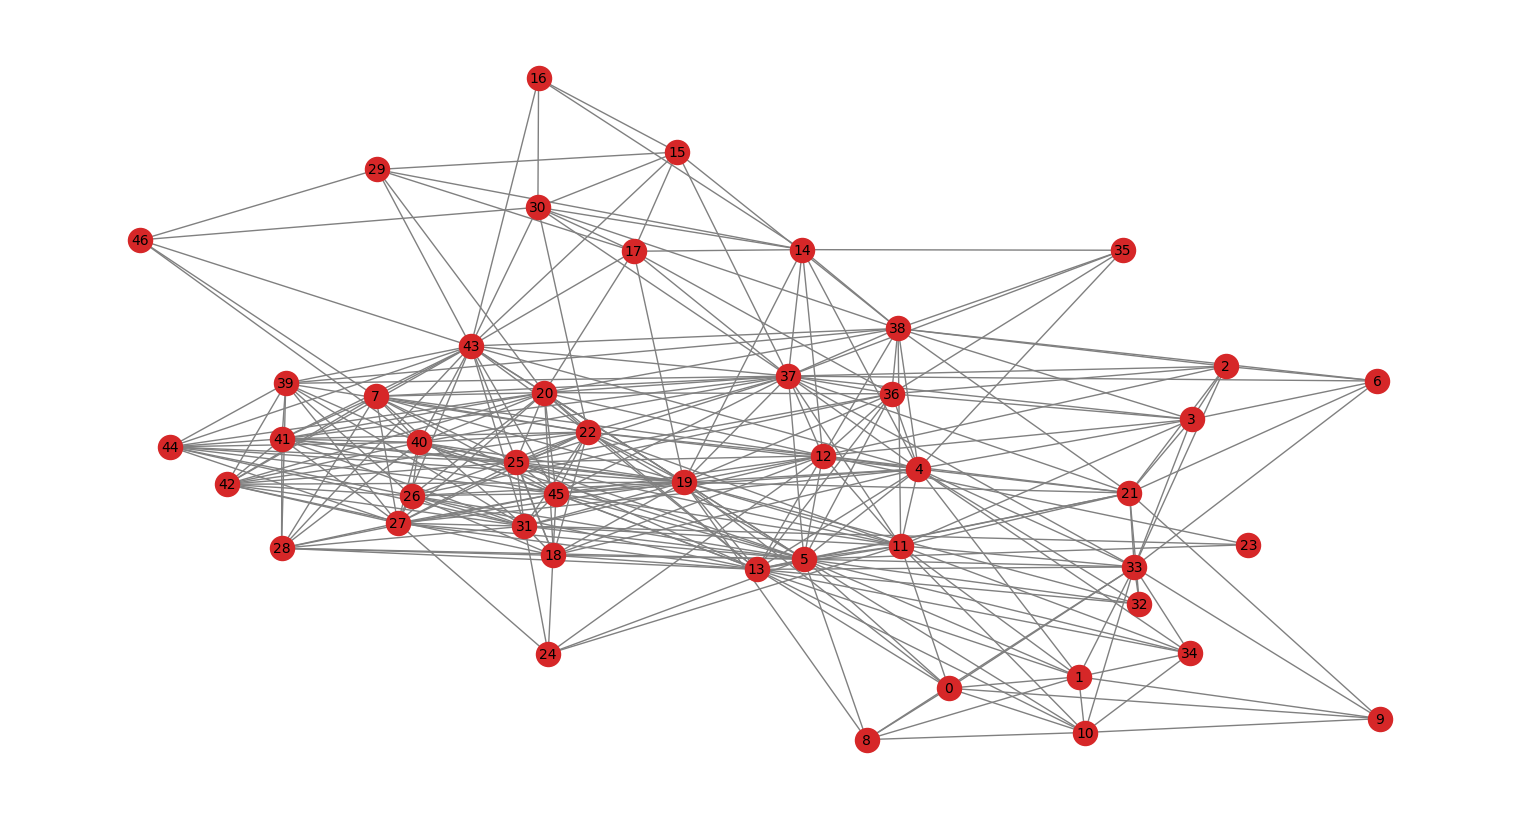

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=300, with_labels=True, font_size=10)
plt.show()

Vamos determinar as medidas quer queremos observar nas redes reais e nos modelos, que serão grau médio (1° momento), 2° momento, variância do grau, average clustering, assortatividade, coeficiente de complexidade, transitividade e diâmetro:

In [5]:
def measures(G):

    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M

    def coef_complexity(G):

      momment_k1 = momment_of_degree_distribution(G, 1)
      momment_k2 = momment_of_degree_distribution(G, 2)

      coef_complexity = momment_k2/momment_k1

      return coef_complexity

    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)

    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_clustering = nx.average_clustering(G)
    av_spl = nx.average_shortest_path_length(G)
    assortativity = nx.degree_assortativity_coefficient(G)
    complexity = coef_complexity(G)
    transitivity = nx.transitivity(G)
    diameter = nx.diameter(G)

    return  k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter

#### Classificação

Para a classificação das redes serão usados os modelos Erdős–Rényi (grafos aleatórios, ER), Barabási–Albert (BA), Watts–Strogatz (small-world, WS) e Waxman (WM).

In [6]:
# função para classificação

def classificacao(G):

  k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter  = measures(G)
  X_net = [k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter]

  cl = ['ER','WS','BA', 'WM']

  #ER networks
  X = []
  y = []
  n_nets = 30
  av_degree = k1
  p = av_degree/(N-1)
  for i in range(0,n_nets):
      GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
      Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
      GER = GER.subgraph(Gcc[0])
      GER = nx.convert_node_labels_to_integers(GER, first_label=0)
      k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter = measures(GER)

      if np.isnan(assortativity):
        assortativity = 0.0

      x1 = [k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter]
      X.append(x1)
      y.append(0.0)

  #WS networks
  k = int(av_degree)
  p = 0.1 #probability of rewiring
  for i in range(0,n_nets):
      GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
      Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
      GWS = GWS.subgraph(Gcc[0])
      GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
      k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter = measures(GWS)

      if np.isnan(assortativity):
        assortativity = 0.0

      x2 = [k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter]
      X.append(x2)
      y.append(1.0)

  # BA networks
  m = int(av_degree/2)
  for i in range(0,n_nets):
      GBA = nx.barabasi_albert_graph(N, m, seed=None)
      Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
      GBA = GBA.subgraph(Gcc[0])
      GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
      k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter = measures(GBA)
      x3 = [k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter]

      if np.isnan(assortativity):
        assortativity = 0.0

      X.append(x3)
      y.append(2.0)

  # WM networks
  for i in range(0,n_nets):
      GWM = nx.waxman_graph(N, beta=0.1, alpha=0.1, seed=None)
      Gcc = sorted(nx.connected_components(GWM), key=len, reverse=True)
      GWM = GWM.subgraph(Gcc[0])
      GWM = nx.convert_node_labels_to_integers(GWM, first_label=0)
      k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter = measures(GWM)

      if np.isnan(assortativity):
        assortativity = 0.0

      x4 = [k1, k2, variance, av_clustering, av_spl, assortativity, complexity, transitivity, diameter]
      X.append(x4)
      y.append(3.0)

  X = np.array(X)
  y = np.array(y)

  scaler = StandardScaler().fit(X)
  X = scaler.transform(X)

  X_net_array = np.array(X_net)
  X_net_array = X_net_array.reshape(1,len(X_net_array))
  X_net_array = scaler.transform(X_net_array)
  # print('Xnet:', X_net_array.shape)

  k = 5
  model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
  model.fit(X,y)

  y_pred = model.predict(X_net_array)

  return cl[int(y_pred)], X_net, x1, x2, x3, x4

In [7]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: BA


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
<ipython-input-6-6a14c41b54f9>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


Fazendo a classificação da rede original obtemos que ela seria do modelo Barabási–Albert.

#### PCA

In [8]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df11 = pd.DataFrame(dados, columns=colunas, index=indices)
df11['rede'] = df11.index
df11['tipo'] = 'Biológica'
df11['nome_rede'] = 'Macaque'
df11

k1          k2   variance  av_clustering    av_spl  \
Rede original  13.319149  220.936170  43.536442       0.641223  1.850139   
ER             12.936170  175.702128   8.357628       0.285939  1.732655   
WS             12.000000  145.446809   1.446809       0.492401  1.913043   
BA             10.468085  136.212766  26.631960       0.306519  1.817761   
WM              1.333333    2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.005630   16.587859      0.547243         4   
ER                 -0.072758   13.582237      0.284706         3   
WS                  0.025656   12.120567      0.489796         3   
BA                 -0.185699   13.012195      0.265990         3   
WM                 -1.000000    1.500000      0.000000         2   

                        rede       tipo nome_rede  
Rede original  Rede original  Biológica   Macaque  
ER                        ER  Biológica   Macaque  
WS                        WS  Biológica   Macaque  
BA                        BA  Biológica   Macaque  
WM                        WM  Biológica   Macaque

In [9]:
features = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
       'complexity', 'transitivity', 'diameter']
X = df11[features]

# Normaliza os dados
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Componentes principais
df11_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)

print(df11_loadings)


                    PC1       PC2
k1             1.070013 -0.233872
k2             1.092374  0.022583
variance       0.744862  0.818870
av_clustering  1.065043  0.040313
av_spl         1.040341 -0.297727
assortativity  1.068095 -0.311858
complexity     1.095878  0.007809
transitivity   1.056265 -0.114451
diameter       1.067500  0.307131


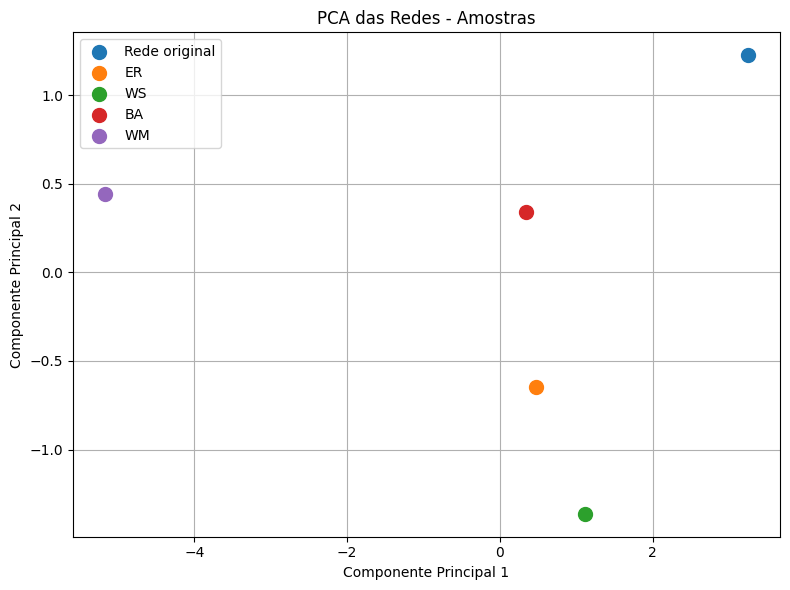

In [10]:
# Componentes principais para cada amostra
df11_pca = pd.DataFrame(components, columns=['PC1', 'PC2'], index=df11.index)
df11_pca['rede'] = df11_pca.index

# Plotando as redes com cores e legenda
plt.figure(figsize=(8,6))

# Usamos um loop para plotar cada rede com cor diferente
for rede in df11_pca['rede'].unique():
    subset = df11_pca[df11_pca['rede'] == rede]
    plt.scatter(subset['PC1'], subset['PC2'], s=100, label=rede)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA das Redes - Amostras')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Na classificação obtemos que o melhor modelo seria o BA e, de acordo com o PCA e o gráfico gerado, temos que o modelo predito e a rede original estão com os pontos próximos no gráfico, indicando que apresentam metricas semelhantes considerando as duas componentes principais.

In [12]:
# função PCA

def pca_(G):

  classe, X_net, x1, x2, x3, x4 = classificacao(G)

  # Junta as listas em uma lista de listas
  dados = [X_net, x1, x2, x3, x4]

  # Define os nomes das redes como índices
  indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

  # Define os nomes das colunas
  colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
            'complexity', 'transitivity', 'diameter']

  # Cria o DataFrame
  df11 = pd.DataFrame(dados, columns=colunas, index=indices)
  df11['rede'] = df11.index


  print('# Tabela com as métricas das redes')
  display(df11)
  print('')


  features = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
        'complexity', 'transitivity', 'diameter']
  X = df11[features]

  # Normaliza os dados
  X = StandardScaler().fit_transform(X)

  pca = PCA(n_components=2)
  components = pca.fit_transform(X)

  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  # Componentes principais
  df11_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)

  print('# Tabela com as componentes principais')
  print(df11_loadings)
  print('')

  # Componentes principais para cada amostra
  df11_pca = pd.DataFrame(components, columns=['PC1', 'PC2'], index=df11.index)
  df11_pca['rede'] = df11_pca.index

  # Plotando as redes com cores e legenda
  plt.figure(figsize=(8,6))

  # Usamos um loop para plotar cada rede com cor diferente
  for rede in df11_pca['rede'].unique():
      subset = df11_pca[df11_pca['rede'] == rede]
      plt.scatter(subset['PC1'], subset['PC2'], s=100, label=rede)

  print('# Gráfico do PCA')
  plt.xlabel('Componente Principal 1')
  plt.ylabel('Componente Principal 2')
  plt.title('PCA das Redes - Amostras')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

### Rede Biológica 2: PDZ-domain interactome

* Uma rede de interações proteína–proteína mediadas por domínios PDZ, extraída do banco de dados PDZBase. Os nós representam proteínas e uma aresta representa uma interação de ligação entre duas proteínas.
* Fonte: https://networks.skewed.de/net/interactome_pdz


In [13]:
g = gt.collection.ns["interactome_pdz"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 161
Número de arestas: 209


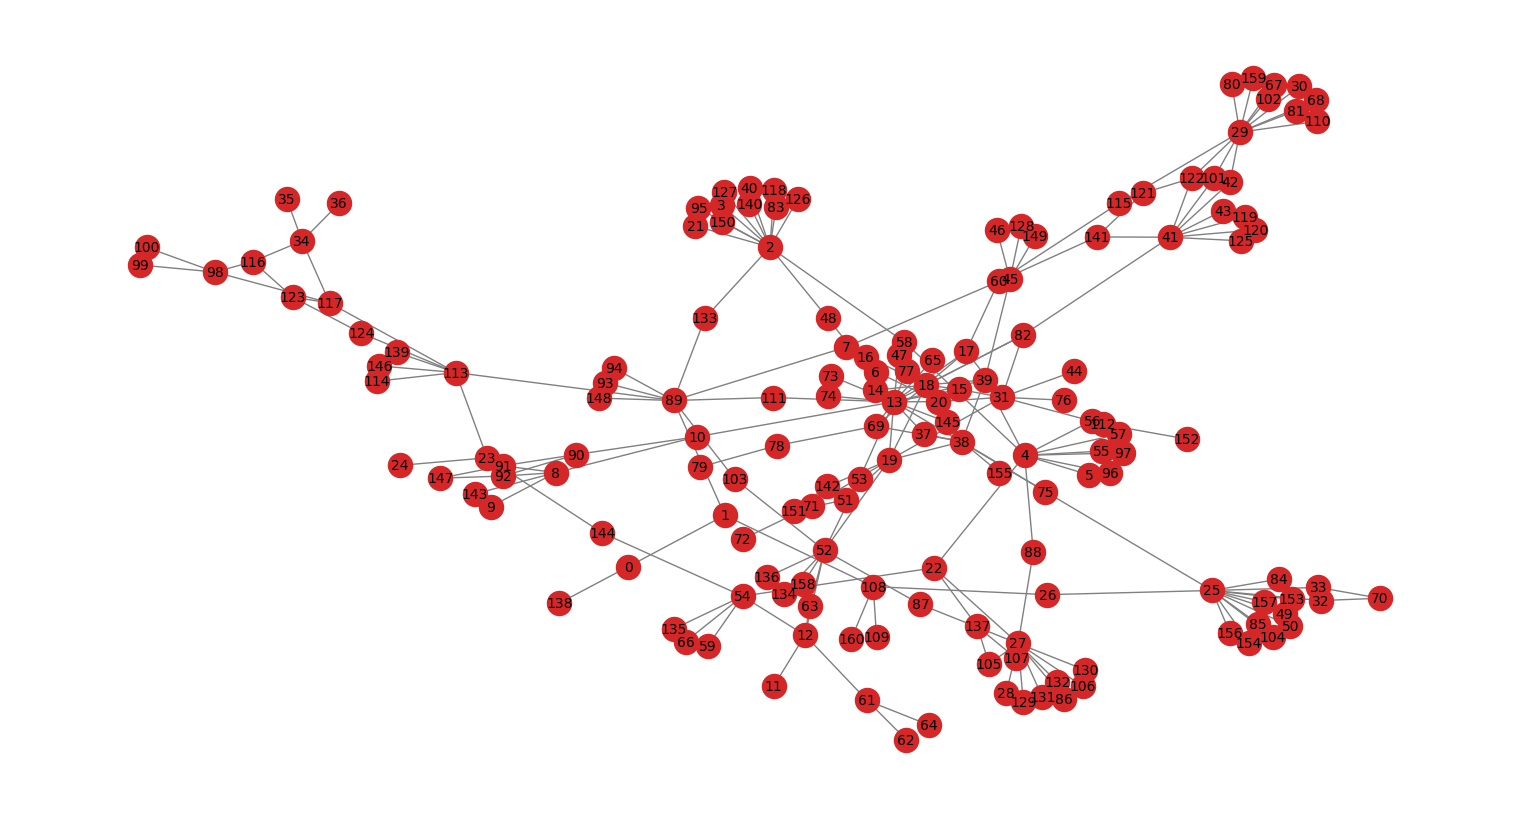

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=300, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: BA


<ipython-input-6-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df12 = pd.DataFrame(dados, columns=colunas, index=indices)
df12['rede'] = df12.index
df12['tipo'] = 'Biológica'
df12['nome_rede'] = 'PDZ'
df12

k1         k2  variance  av_clustering     av_spl  \
Rede original  2.596273  15.254658  8.514023       0.007005   5.326087   
ER             2.612245   8.435374  1.611551       0.018821   5.742335   
WS             2.000000   4.151724  0.151724       0.000000  24.007471   
BA             1.987578  11.925466  7.975001       0.000000   4.948913   
WM             2.000000   4.516129  0.516129       0.032258   6.726882   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.465853    5.875598      0.002944        10   
ER                 -0.108246    3.229167      0.014019        12   
WS                  0.007820    2.075862      0.000000        71   
BA                 -0.241609    6.000000      0.000000        11   
WM                 -0.148148    2.258065      0.076923        16   

                        rede       tipo nome_rede  
Rede original  Rede original  Biológica       PDZ  
ER                        ER  Biológica       PDZ  
WS                        WS  Biológica       PDZ  
BA                        BA  Biológica       PDZ  
WM                        WM  Biológica       PDZ

#### PCA

# Tabela com as métricas das redes


<ipython-input-6-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2  variance  av_clustering     av_spl  \
Rede original  2.596273  15.254658  8.514023       0.007005   5.326087   
ER             2.612245   8.435374  1.611551       0.018821   5.742335   
WS             2.000000   4.151724  0.151724       0.000000  24.007471   
BA             1.987578  11.925466  7.975001       0.000000   4.948913   
WM             2.000000   4.516129  0.516129       0.032258   6.726882   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.465853    5.875598      0.002944        10   
ER                 -0.108246    3.229167      0.014019        12   
WS                  0.007820    2.075862      0.000000        71   
BA                 -0.241609    6.000000      0.000000        11   
WM                 -0.148148    2.258065      0.076923        16   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             0.593850  0.183888
k2             1.102987 -0.156926
variance       1.054435 -0.249481
av_clustering -0.299764  1.068709
av_spl        -0.810310 -0.719365
assortativity -1.020487 -0.138466
complexity     1.065831 -0.231986
transitivity  -0.435827  0.960287
diameter      -0.818796 -0.719192

# Gráfico do PCA


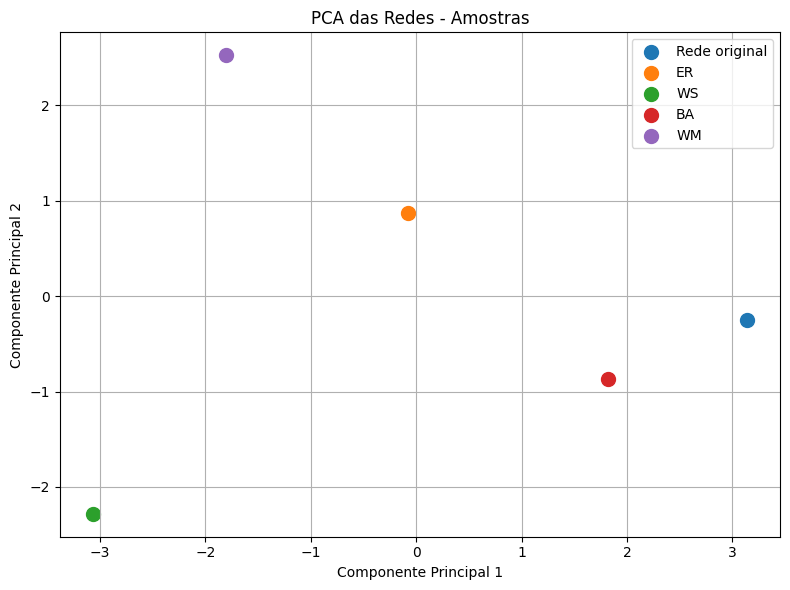

In [ ]:
pca_(G)

Novamente, o modelo predito foi o BA e, de acordo o PCA, esse modelo de fato é próximo da rede original.

### Rede Biológica 3: Yeast transcription network

* Rede de operões (conjunto de genes que estão funcionalmente relacionados e estão agrupados no DNA de bactérias) e suas interações par-a-par, por meio da regulação baseada em fatores de transcrição, na levedura *Saccharomyces cerevisiae*.
* Fonte: https://networks.skewed.de/net/yeast_transcription


In [ ]:
g = gt.collection.ns["yeast_transcription"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 664
Número de arestas: 1065


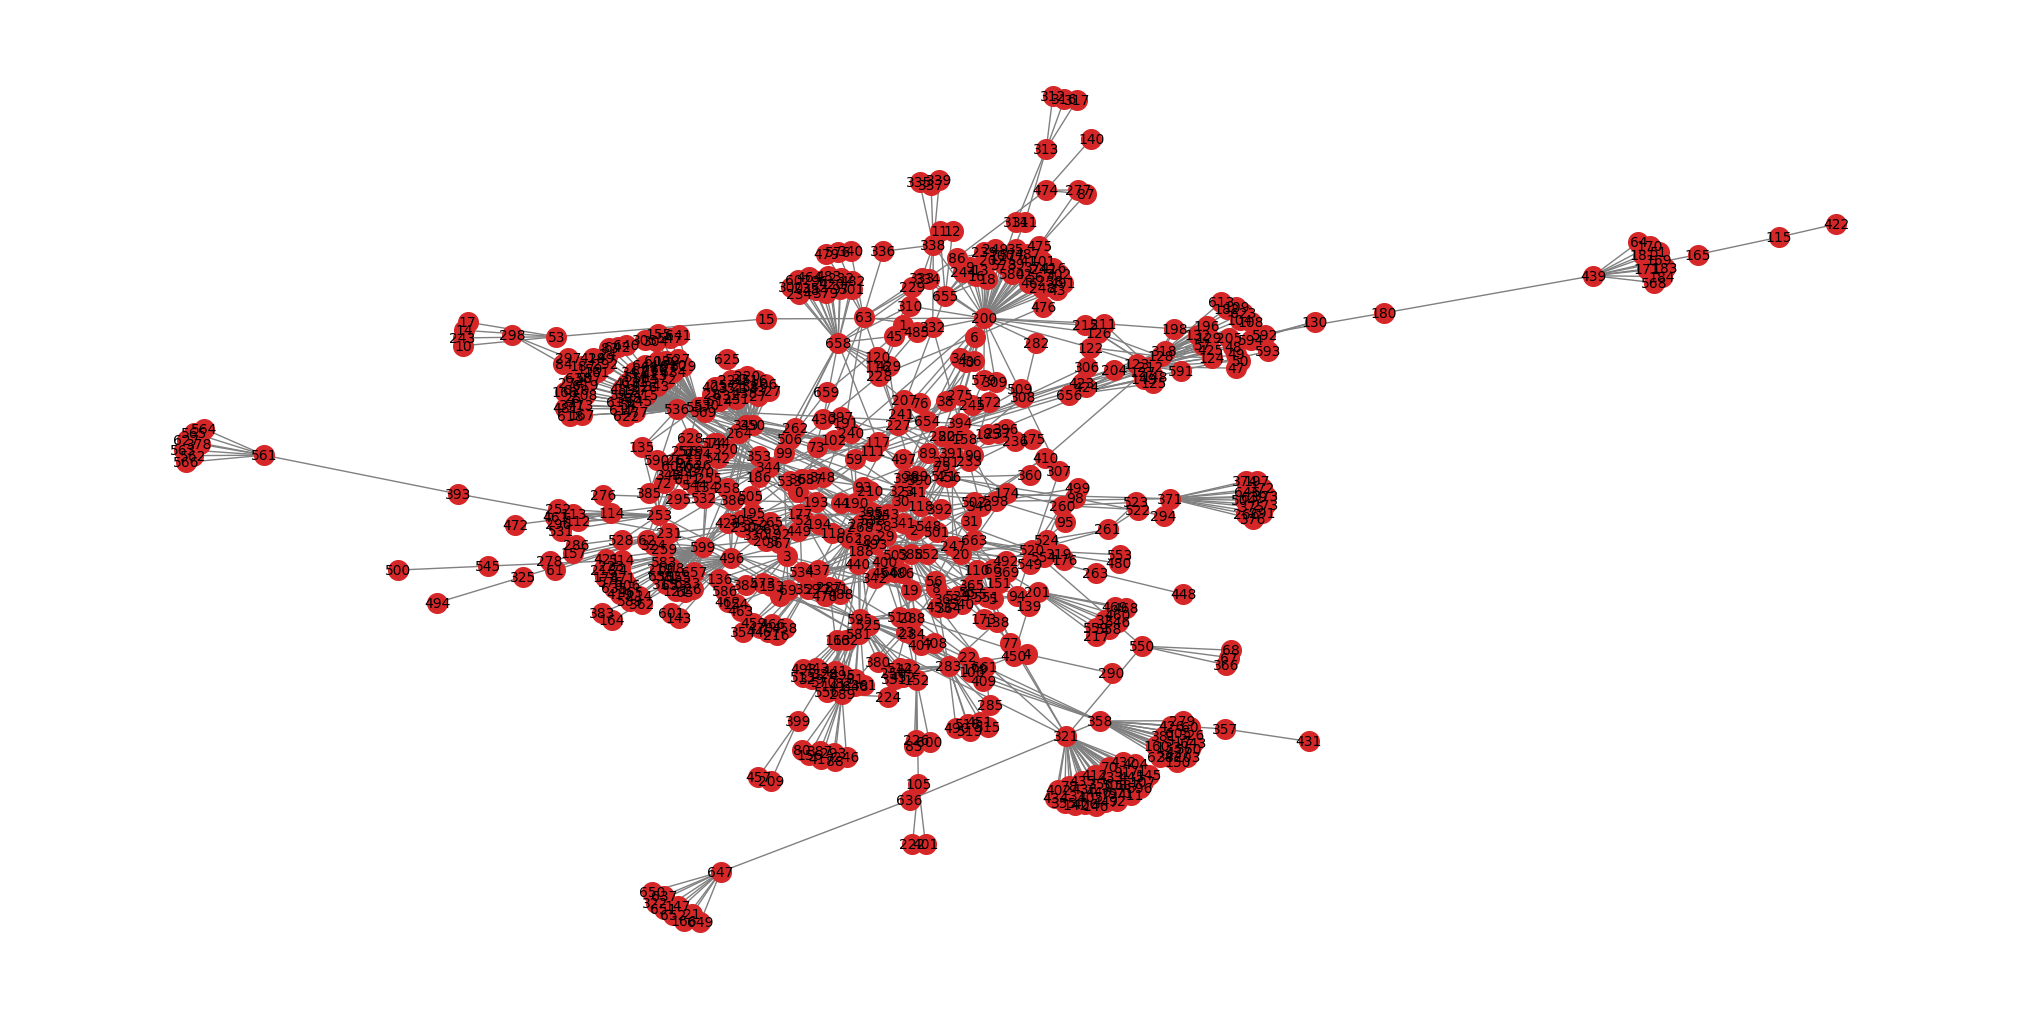

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=200, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: BA


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df13 = pd.DataFrame(dados, columns=colunas, index=indices)
df13['rede'] = df13.index
df13['tipo'] = 'Biológica'
df13['nome_rede'] = 'Yeast'
df13

k1         k2   variance  av_clustering     av_spl  \
Rede original  3.207831  43.286145  32.995963       0.048818   5.200240   
ER             3.333333  13.724359   2.613248       0.005685   5.624300   
WS             2.000000   4.184211   0.184211       0.000000  69.373087   
BA             1.996988  16.590361  12.602401       0.000000   6.026268   
WM             5.418960  36.256881   6.891751       0.022553   4.158286   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.408391   13.493897      0.016233        15   
ER                 -0.027587    4.117308      0.004627        14   
WS                 -0.155932    2.092105      0.000000       207   
BA                 -0.125893    8.307692      0.000000        16   
WM                  0.099959    6.690745      0.023503         9   

                        rede       tipo nome_rede  
Rede original  Rede original  Biológica     Yeast  
ER                        ER  Biológica     Yeast  
WS                        WS  Biológica     Yeast  
BA                        BA  Biológica     Yeast  
WM                        WM  Biológica     Yeast

#### PCA

# Tabela com as métricas das redes


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2   variance  av_clustering     av_spl  \
Rede original  3.207831  43.286145  32.995963       0.048818   5.200240   
ER             3.333333  13.724359   2.613248       0.005685   5.624300   
WS             2.000000   4.184211   0.184211       0.000000  69.373087   
BA             1.996988  16.590361  12.602401       0.000000   6.026268   
WM             5.418960  36.256881   6.891751       0.022553   4.158286   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.408391   13.493897      0.016233        15   
ER                 -0.027587    4.117308      0.004627        14   
WS                 -0.155932    2.092105      0.000000       207   
BA                 -0.125893    8.307692      0.000000        16   
WM                  0.099959    6.690745      0.023503         9   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             0.626114  0.856282
k2             1.093972  0.060208
variance       0.920297 -0.630876
av_clustering  1.006798 -0.253725
av_spl        -0.845702 -0.358882
assortativity -0.340946  1.052858
complexity     0.994984 -0.449989
transitivity   0.887051  0.479119
diameter      -0.840264 -0.371591

# Gráfico do PCA


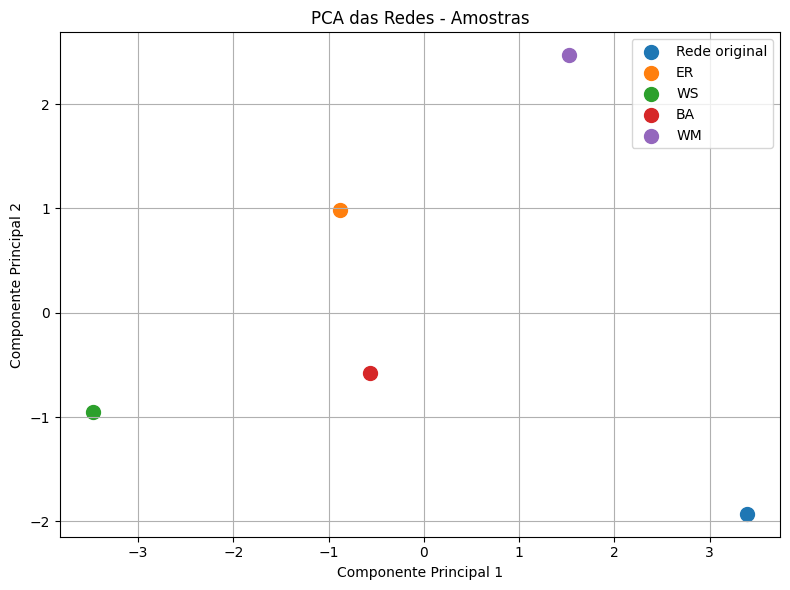

In [ ]:
pca_(G)

Mais uma vez o modelo predito foi o BA e esse resultado vai de encontro com o que é mostrado no gráfico do PCA.

Portanto, temos que para as redes biológicas utilizadas o modelo de Barabási–Albert (BA) é o mais adequado.

## **Redes Sociais**

### Rede Sociais 1: Dutch literacy criticism

* Uma rede de críticas entre autores literários holandeses em 1976. A aresta direcionada (i, j) indica que o autor i fez um julgamento sobre a obra do autor j em uma entrevista ou resenha.
* Fonte: https://networks.skewed.de/net/dutch_criticism


In [ ]:
g = gt.collection.ns["dutch_criticism"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 35
Número de arestas: 80


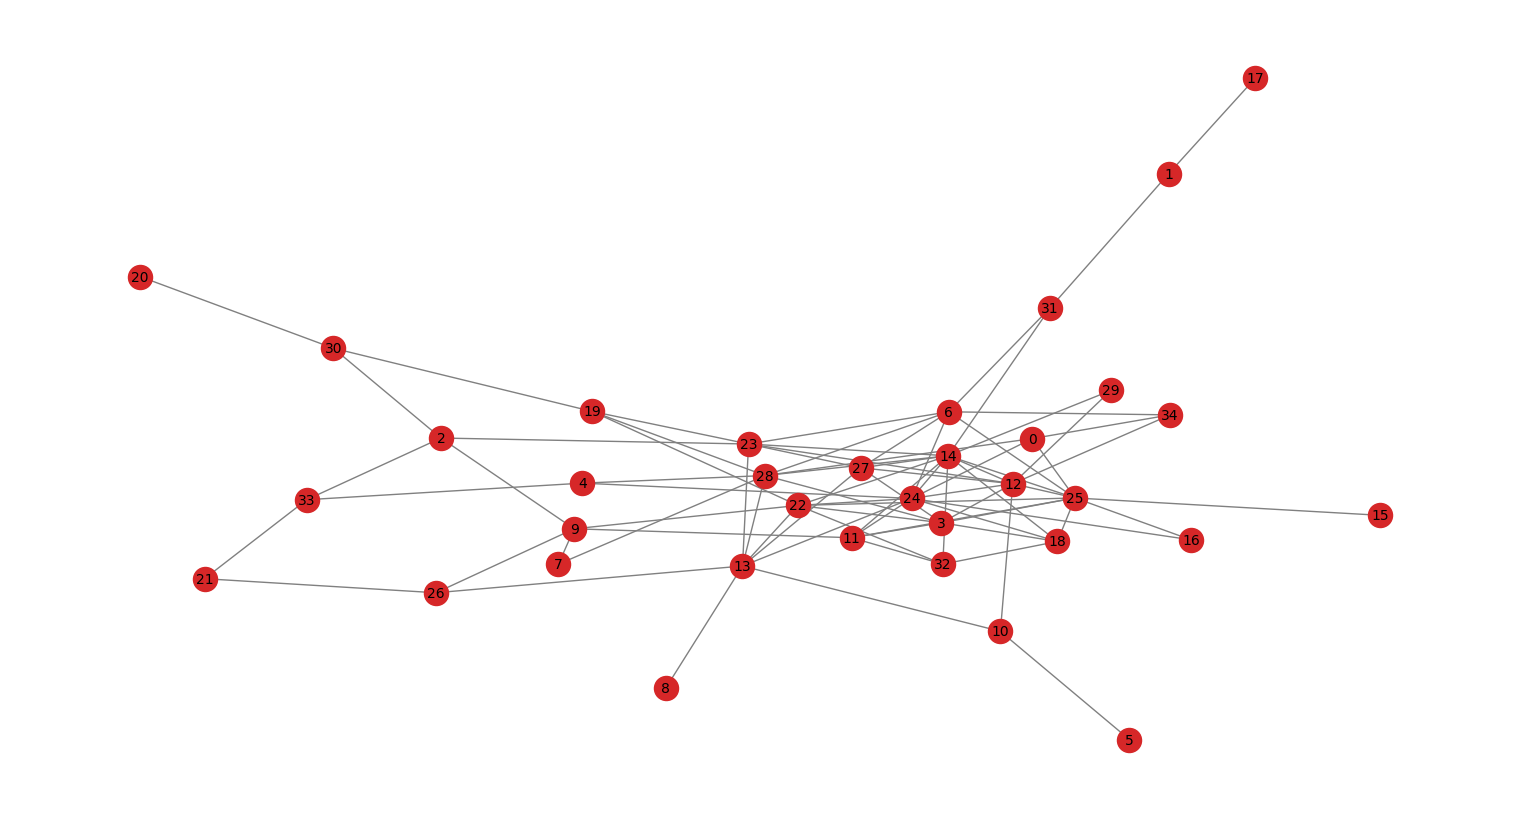

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=300, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: ER


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df21 = pd.DataFrame(dados, columns=colunas, index=indices)
df21['rede'] = df21.index
df21['tipo'] = 'Social'
df21['nome_rede'] = 'Criticism'
df21

k1         k2   variance  av_clustering    av_spl  \
Rede original  4.571429  29.657143   8.759184       0.116539  2.705882   
ER             4.685714  24.857143   2.901224       0.104558  2.398319   
WS             4.000000  16.514286   0.514286       0.379048  3.216807   
BA             3.771429  27.085714  12.862041       0.355859  2.299160   
WM             1.333333   2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.064368    6.487500      0.164009         7   
ER                 -0.266244    5.304878      0.101983         5   
WS                 -0.030578    4.128571      0.356164         6   
BA                 -0.450925    7.181818      0.102941         4   
WM                 -1.000000    1.500000      0.000000         2   

                        rede    tipo  nome_rede  
Rede original  Rede original  Social  Criticism  
ER                        ER  Social  Criticism  
WS                        WS  Social  Criticism  
BA                        BA  Social  Criticism  
WM                        WM  Social  Criticism

#### PCA

# Tabela com as métricas das redes


<ipython-input-7-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2   variance  av_clustering    av_spl  \
Rede original  4.571429  29.657143   8.759184       0.116539  2.705882   
ER             4.685714  24.857143   2.901224       0.104558  2.398319   
WS             4.000000  16.514286   0.514286       0.379048  3.216807   
BA             3.771429  27.085714  12.862041       0.355859  2.299160   
WM             1.333333   2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.064368    6.487500      0.164009         7   
ER                 -0.266244    5.304878      0.101983         5   
WS                 -0.030578    4.128571      0.356164         6   
BA                 -0.450925    7.181818      0.102941         4   
WM                 -1.000000    1.500000      0.000000         2   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             1.040328  0.092962
k2             0.973919  0.519776
variance       0.531122  0.905989
av_clustering  0.706417 -0.198928
av_spl         1.020124 -0.453840
assortativity  1.060229 -0.229117
complexity     0.918522  0.628849
transitivity   0.784453 -0.758156
diameter       1.013591 -0.217621

# Gráfico do PCA


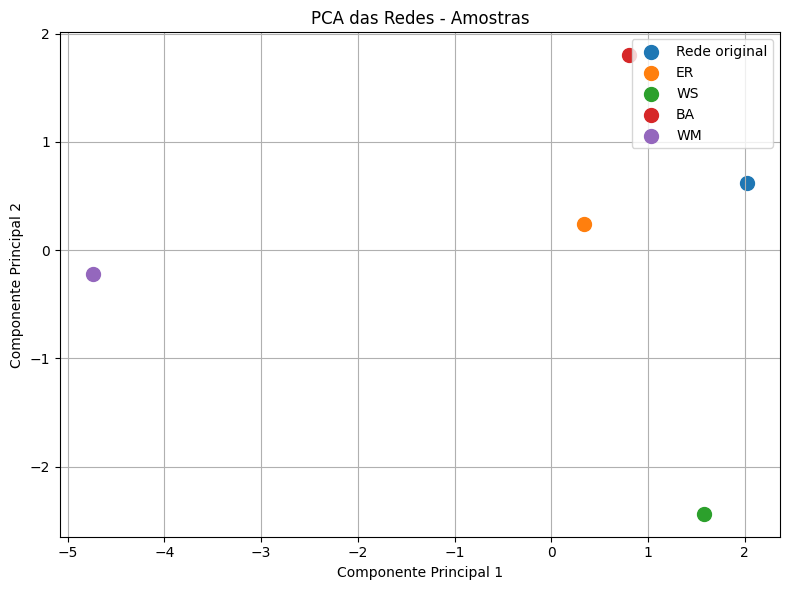

In [ ]:
pca_(G)

A classificação dessa rede obteve como resultado o modelo de Erdős–Rényi (ER) e de acordo com o PCA e o gráfico, de fato, esse modelo e a rede original são próximas. Porém, vale observar que o modelo de Barabási–Albert (BA) também seria um resultado satisfatório.

### Rede Social 2: Barnes-Burkett elite affiliations

* Uma pequena rede bipartida das afiliações entre indivíduos da elite e os conselhos corporativos, museus, universidades ou clubes sociais aos quais pertenciam, com dados de 1962.
* Fonte: https://networks.skewed.de/net/florentine_families


In [ ]:
g = gt.collection.ns["elite"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 44
Número de arestas: 99


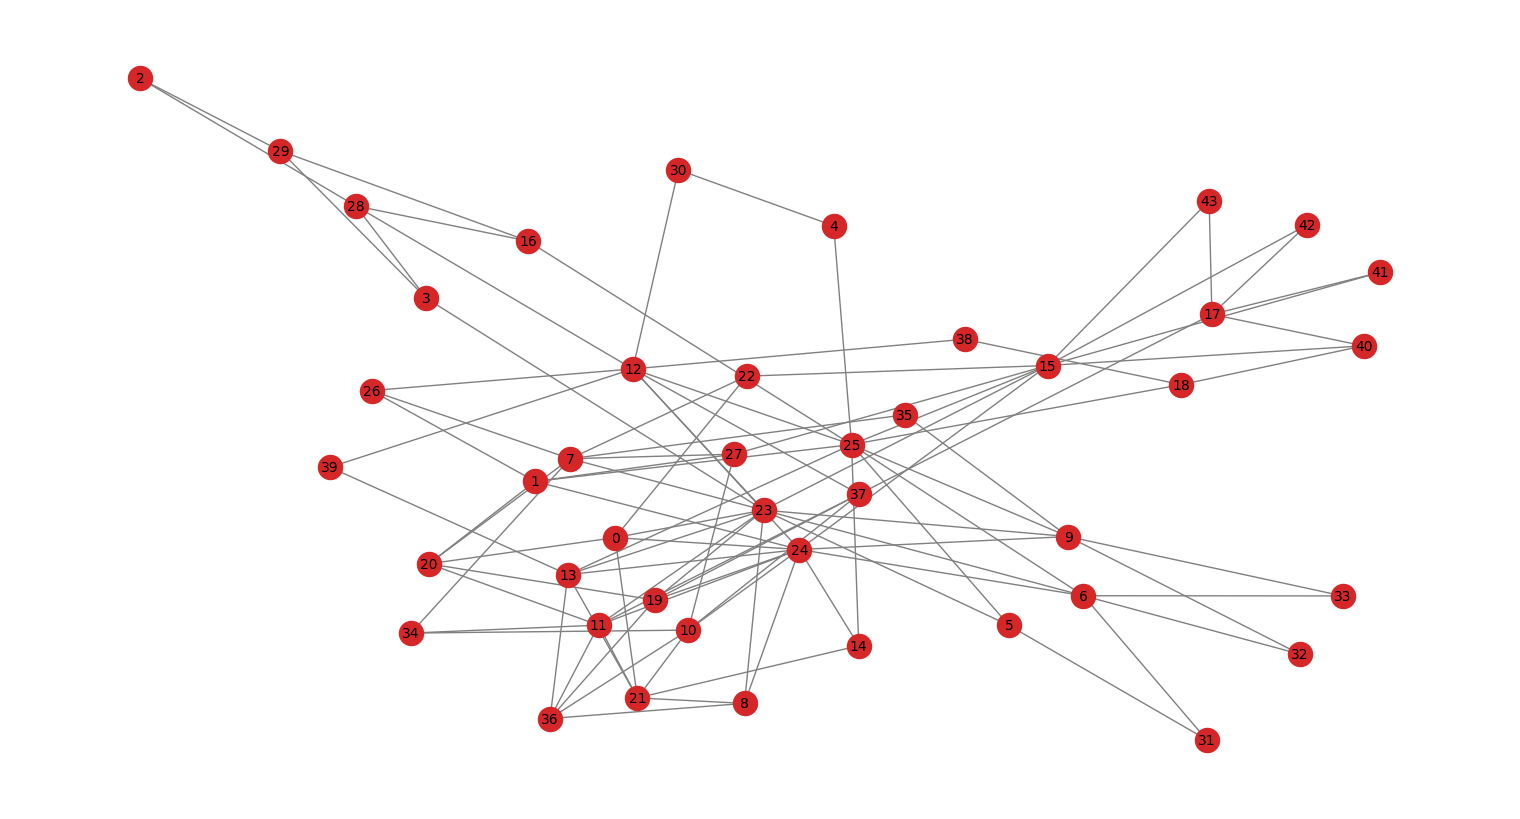

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=300, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [14]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: BA


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
<ipython-input-6-6a14c41b54f9>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [15]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df22 = pd.DataFrame(dados, columns=colunas, index=indices)
df22['rede'] = df22.index
df22['tipo'] = 'Social'
df22['nome_rede'] = 'Elite'
df22

k1          k2   variance  av_clustering    av_spl  \
Rede original  13.319149  220.936170  43.536442       0.641223  1.850139   
ER             13.191489  181.531915   7.516523       0.285475  1.728955   
WS             12.000000  144.851064   0.851064       0.507184  1.938020   
BA             10.468085  149.872340  40.291535       0.387931  1.797410   
WM              1.333333    2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.005630   16.587859      0.547243         4   
ER                 -0.078695   13.761290      0.274520         3   
WS                 -0.006099   12.070922      0.505445         3   
BA                 -0.250517   14.317073      0.289377         3   
WM                 -1.000000    1.500000      0.000000         2   

                        rede    tipo nome_rede  
Rede original  Rede original  Social     Elite  
ER                        ER  Social     Elite  
WS                        WS  Social     Elite  
BA                        BA  Social     Elite  
WM                        WM  Social     Elite

#### PCA

# Tabela com as métricas das redes


/usr/local/lib/python3.11/dist-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
<ipython-input-6-6a14c41b54f9>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1          k2   variance  av_clustering    av_spl  \
Rede original  13.319149  220.936170  43.536442       0.641223  1.850139   
ER             13.744681  194.978723   6.062472       0.291857  1.709528   
WS             12.000000  144.638298   0.638298       0.547791  1.970398   
BA             10.468085  135.148936  25.568130       0.312970  1.835338   
WM              1.333333    2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.005630   16.587859      0.547243         4   
ER                 -0.024903   14.185759      0.293027         3   
WS                 -0.021927   12.053191      0.546679         4   
BA                 -0.150806   12.910569      0.282594         3   
WM                 -1.000000    1.500000      0.000000         2   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             1.058349 -0.073947
k2             1.050980  0.152831
variance       0.640949  0.887163
av_clustering  1.062875 -0.036430
av_spl         1.035101 -0.260920
assortativity  1.079113 -0.115862
complexity     1.074623  0.166092
transitivity   1.059962 -0.188039
diameter       1.048148 -0.187312

# Gráfico do PCA


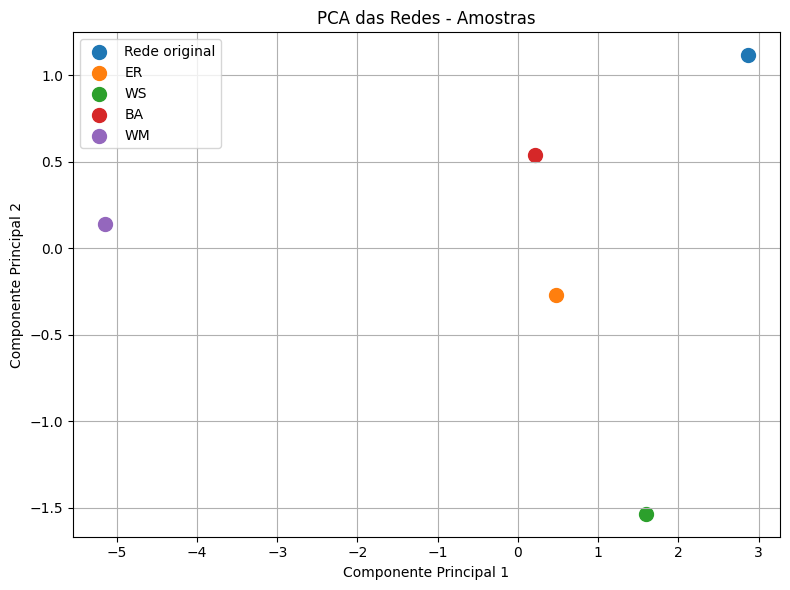

In [16]:
pca_(G)

Novamente, o modelo predito foi o BA e segundo o PCA, de fato, esse modelo e a rede original estão próximos.

### Rede Social 3: Montreal street gangs

* Rede que representa as relações entre gangues, obtida a partir do banco de dados central de inteligência da Polícia de Montreal, cobrindo o período de 2004 a 2007. Os nós representam as gangues, e uma aresta indica algum tipo de relação entre duas gangues (conforme identificado por meio de entrevistas com membros das próprias gangues).
* Fonte: https://networks.skewed.de/net/montreal


In [ ]:
g = gt.collection.ns["montreal"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 29
Número de arestas: 75


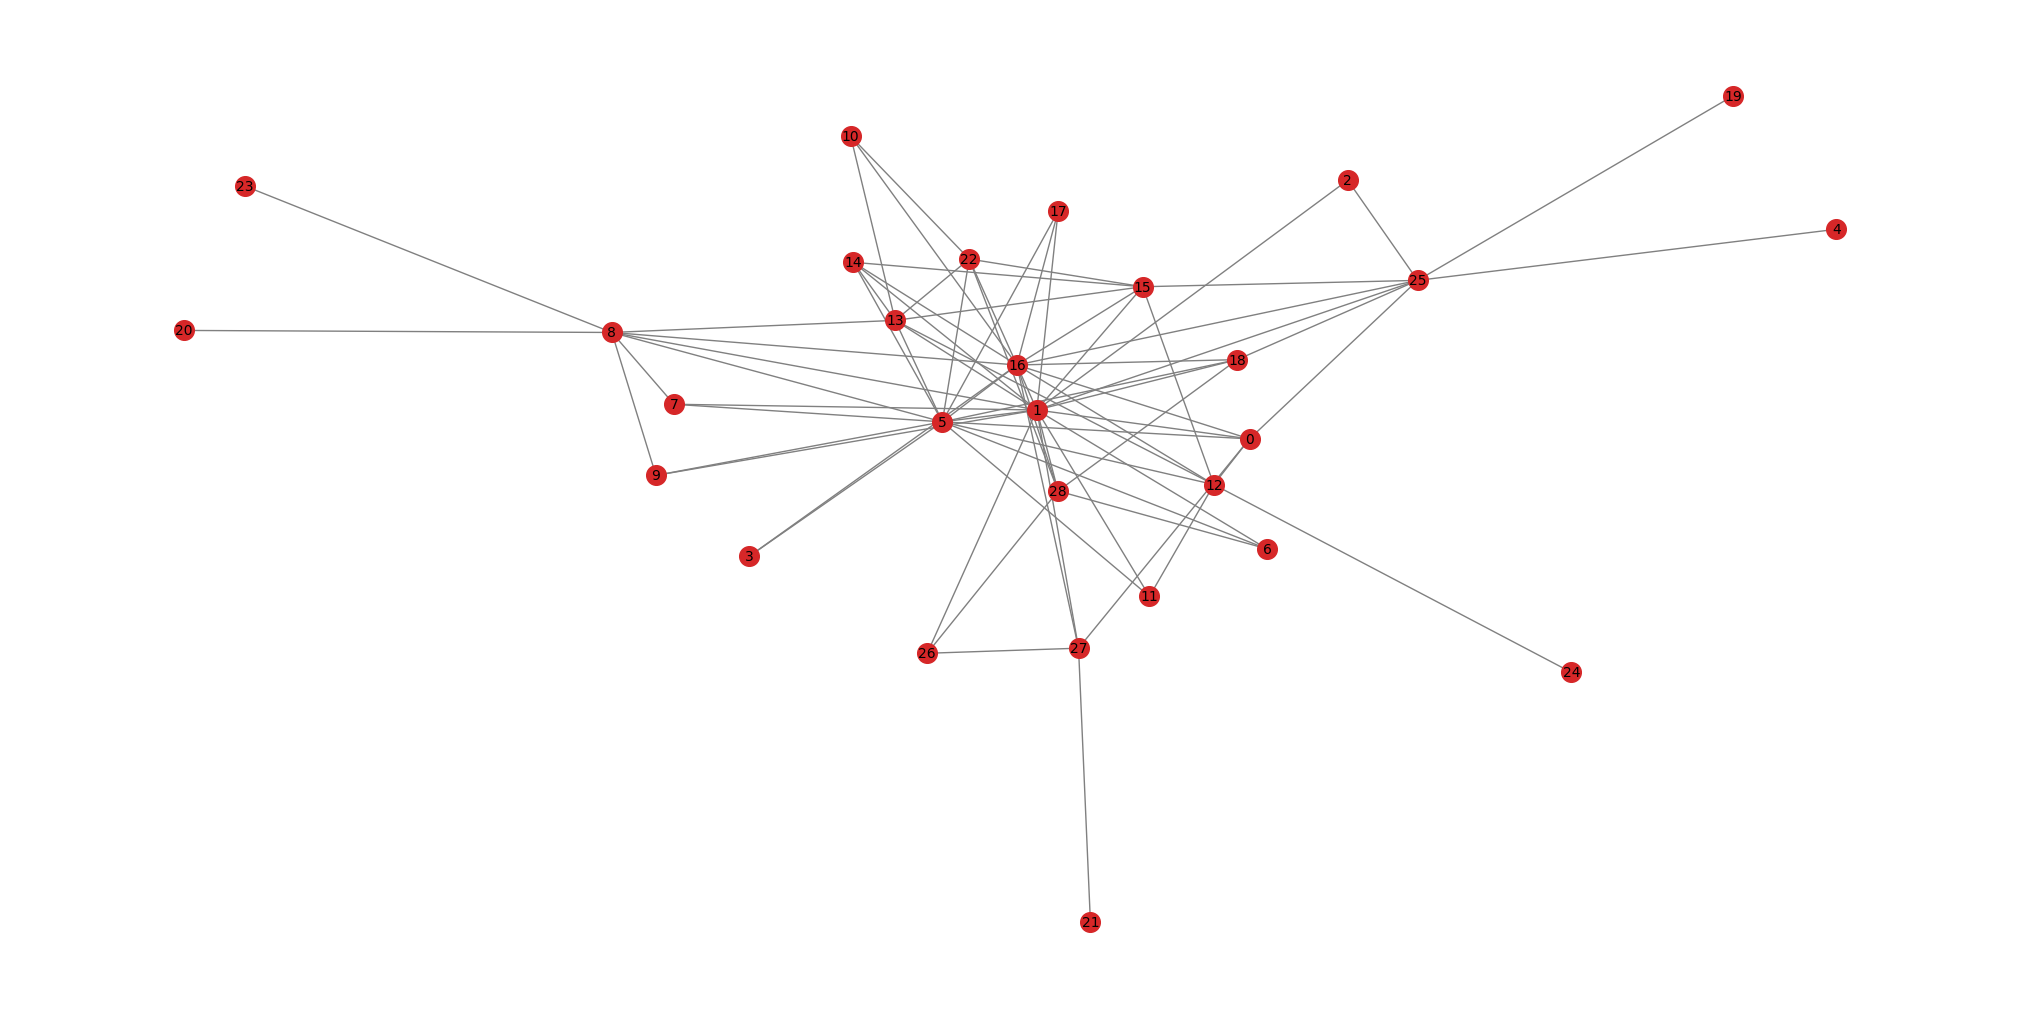

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=200, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: BA


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df23 = pd.DataFrame(dados, columns=colunas, index=indices)
df23['rede'] = df23.index
df23['tipo'] = 'Social'
df23['nome_rede'] = 'Montreal'
df23

k1         k2   variance  av_clustering    av_spl  \
Rede original  5.172414  45.655172  18.901308       0.472010  2.152709   
ER             4.689655  24.758621   2.765755       0.167542  2.206897   
WS             4.000000  16.413793   0.413793       0.466667  3.411330   
BA             3.724138  26.689655  12.820452       0.316295  2.137931   
WM             1.333333   2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.360912    8.826667      0.337308         4   
ER                 -0.222449    5.279412      0.154639         4   
WS                 -0.079526    4.103448      0.433333         7   
BA                 -0.501477    7.166667      0.099099         4   
WM                 -1.000000    1.500000      0.000000         2   

                        rede    tipo nome_rede  
Rede original  Rede original  Social  Montreal  
ER                        ER  Social  Montreal  
WS                        WS  Social  Montreal  
BA                        BA  Social  Montreal  
WM                        WM  Social  Montreal

#### PCA

# Tabela com as métricas das redes


<ipython-input-7-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2   variance  av_clustering    av_spl  \
Rede original  5.172414  45.655172  18.901308       0.472010  2.152709   
ER             4.689655  24.758621   2.765755       0.167542  2.206897   
WS             4.000000  16.413793   0.413793       0.466667  3.411330   
BA             3.724138  26.689655  12.820452       0.316295  2.137931   
WM             1.333333   2.000000   0.222222       0.000000  1.333333   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.360912    8.826667      0.337308         4   
ER                 -0.222449    5.279412      0.154639         4   
WS                 -0.079526    4.103448      0.433333         7   
BA                 -0.501477    7.166667      0.099099         4   
WM                 -1.000000    1.500000      0.000000         2   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             1.014082  0.247353
k2             0.868334  0.690160
variance       0.561212  0.927752
av_clustering  1.058773 -0.023898
av_spl         0.854366 -0.707345
assortativity  0.987810 -0.375195
complexity     0.842738  0.718028
transitivity   0.973607 -0.388602
diameter       0.859118 -0.695248

# Gráfico do PCA


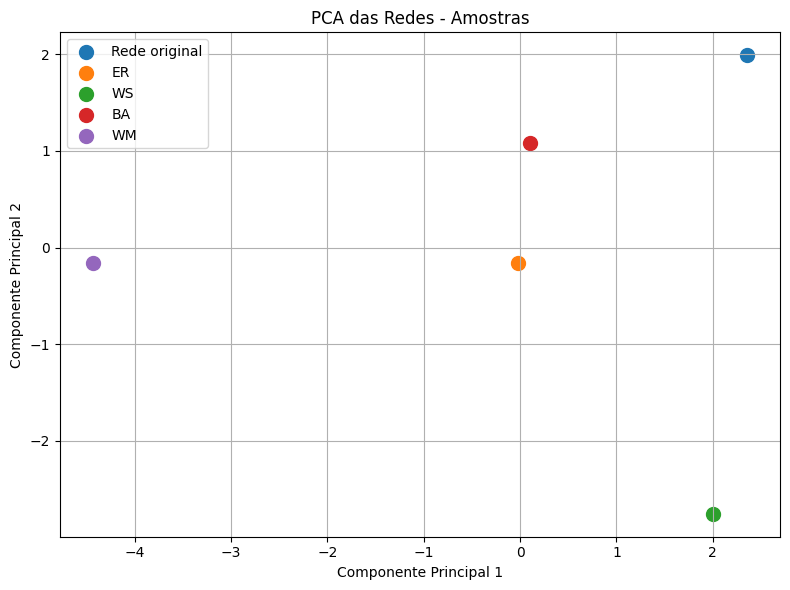

In [ ]:
pca_(G)

Mais uma vez o modelo BA se destacou.

Portanto, temos que a rede Barabási–Albert (BA) apresentou os melhores resultados para as redes sociais, assim como para as biológicas. Entretanto, vale notar que o modelo Erdős–Rényi (ER) não ficou muito longe em comparação com o modelo BA nos gráficos de PCA para as redes sociais, isso é mais evidente na primeira rede social.

## **Redes Tecnológicas**

### Rede Tecnológica 1: Internet topology - Globenet

* Um dos diversos snapshots do grafo da Internet no nível de Ponto de Presença (PoP) (que está entre os níveis IP e AS), coletados de várias partes do mundo e em diferentes períodos. Os primeiros snapshots são da ARPANET (1969–1972), com alguns adicionais anteriores ao ano 2000. A maioria é de 2006 em diante. Os metadados incluem tipo ou velocidade do link, longitudes e latitudes dos nós, URL e data do registro. Será usado a rede chamada Globenet.
* Fonte: https://networks.skewed.de/net/internet_top_pop

In [ ]:
g = gt.collection.ns["internet_top_pop/Globenet"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 67
Número de arestas: 95


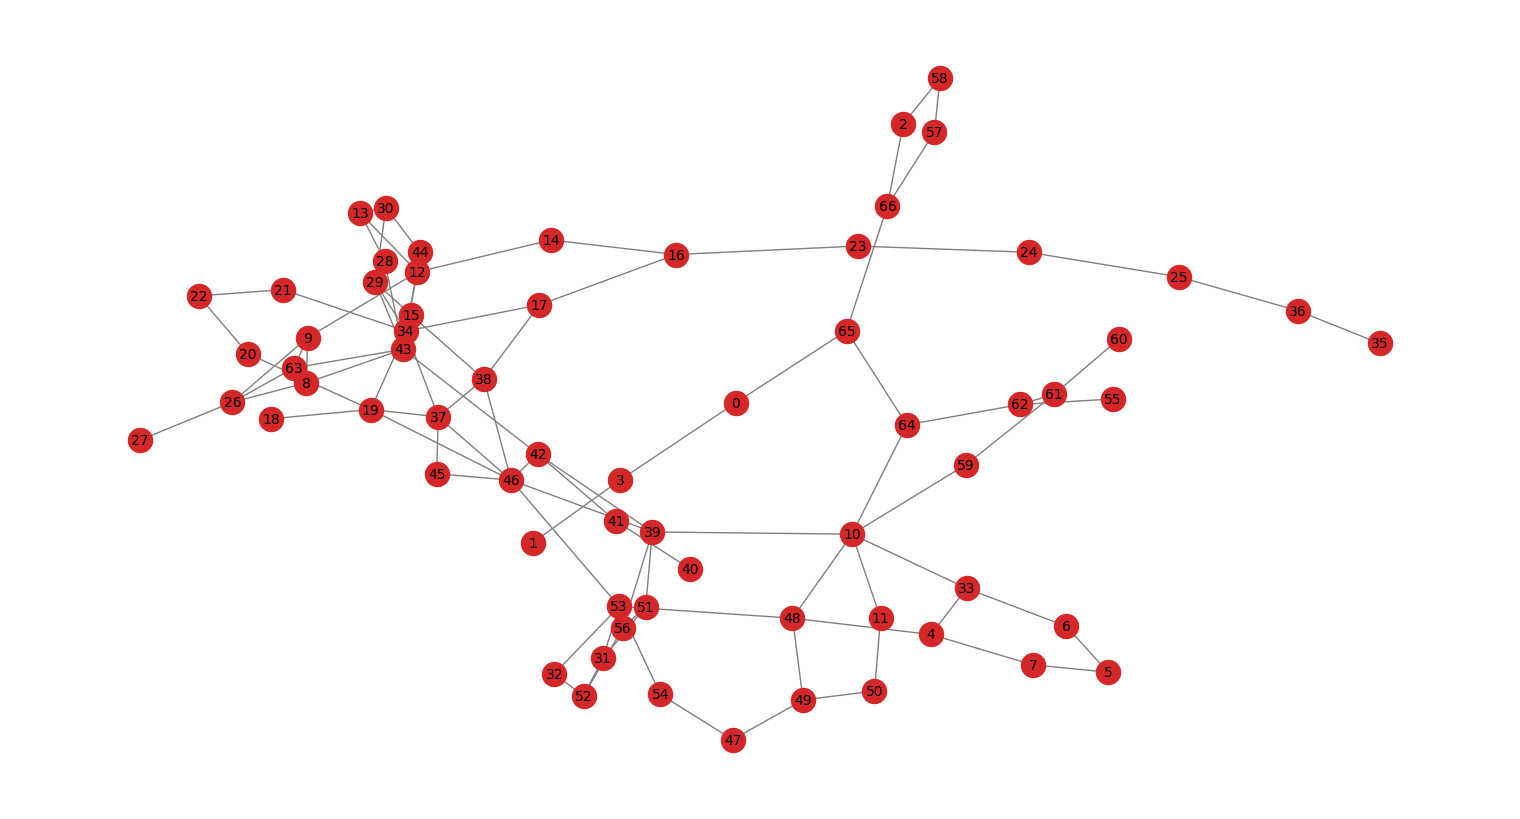

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(15, 8))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=300, with_labels=True, font_size=10)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: ER


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df31 = pd.DataFrame(dados, columns=colunas, index=indices)
df31['rede'] = df31.index
df31['tipo'] = 'Tecnológica'
df31['nome_rede'] = 'Globenet'
df31

k1         k2  variance  av_clustering     av_spl  \
Rede original  2.835821   9.850746  1.808866        0.08145   5.231569   
ER             2.807018   9.508772  1.629424        0.02807   4.103383   
WS             2.000000   4.208955  0.208955        0.00000  12.361827   
BA             1.970149  10.059701  6.178213        0.00000   4.113071   
WM             1.666667   3.333333  0.555556        0.00000   2.066667   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.259377    3.473684      0.140426        15   
ER                 -0.136114    3.387500      0.031414         9   
WS                  0.095613    2.104478      0.000000        34   
BA                 -0.289611    5.106061      0.000000        10   
WM                 -0.333333    2.000000      0.000000         4   

                        rede         tipo nome_rede  
Rede original  Rede original  Tecnológica  Globenet  
ER                        ER  Tecnológica  Globenet  
WS                        WS  Tecnológica  Globenet  
BA                        BA  Tecnológica  Globenet  
WM                        WM  Tecnológica  Globenet

#### PCA

# Tabela com as métricas das redes


<ipython-input-9-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2  variance  av_clustering     av_spl  \
Rede original  2.835821   9.850746  1.808866        0.08145   5.231569   
ER             2.807018   9.508772  1.629424        0.02807   4.103383   
WS             2.000000   4.208955  0.208955        0.00000  12.361827   
BA             1.970149  10.059701  6.178213        0.00000   4.113071   
WM             1.666667   3.333333  0.555556        0.00000   2.066667   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.259377    3.473684      0.140426        15   
ER                 -0.136114    3.387500      0.031414         9   
WS                  0.095613    2.104478      0.000000        34   
BA                 -0.289611    5.106061      0.000000        10   
WM                 -0.333333    2.000000      0.000000         4   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             0.990741  0.230464
k2             0.947782 -0.460829
variance       0.300131 -0.870248
av_clustering  1.015593  0.317416
av_spl        -0.205880  0.861500
assortativity  0.647270  0.884642
complexity     0.582710 -0.766431
transitivity   0.987582  0.337433
diameter      -0.152295  0.883893

# Gráfico do PCA


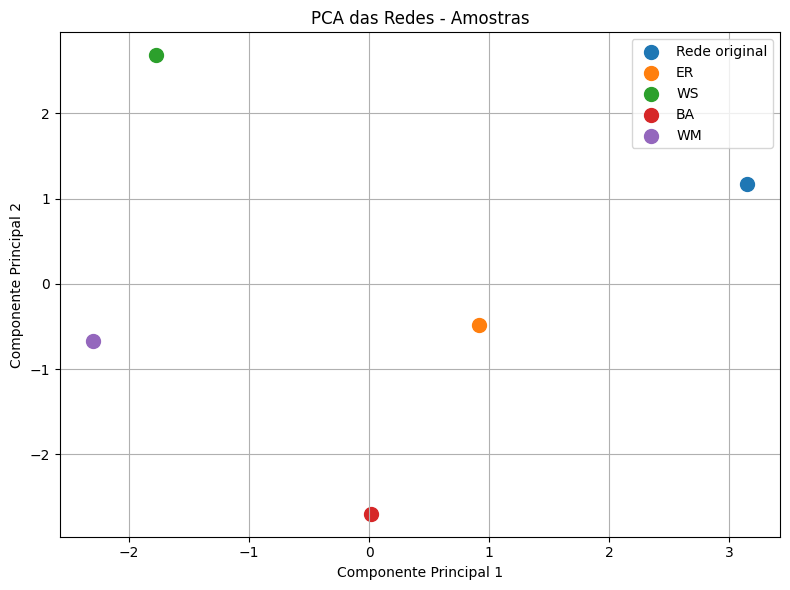

In [ ]:
pca_(G)

Na classificação obtemos que o melhor modelo seria o ER e, de acordo com o PCA e o gráfico, temos que o modelo predito e a rede original de fato são semelhantes.

### Rede Tecnológica 2: Internet topology - Kdl

* Um dos diversos snapshots do grafo da Internet no nível de Ponto de Presença (PoP) (que está entre os níveis IP e AS), coletados de várias partes do mundo e em diferentes períodos. Os primeiros snapshots são da ARPANET (1969–1972), com alguns adicionais anteriores ao ano 2000. A maioria é de 2006 em diante. Os metadados incluem tipo ou velocidade do link, longitudes e latitudes dos nós, URL e data do registro. Será usado a rede chamada Kdl.
* Fonte: https://networks.skewed.de/net/internet_top_pop

In [ ]:
g = gt.collection.ns["internet_top_pop/Kdl"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 754
Número de arestas: 895


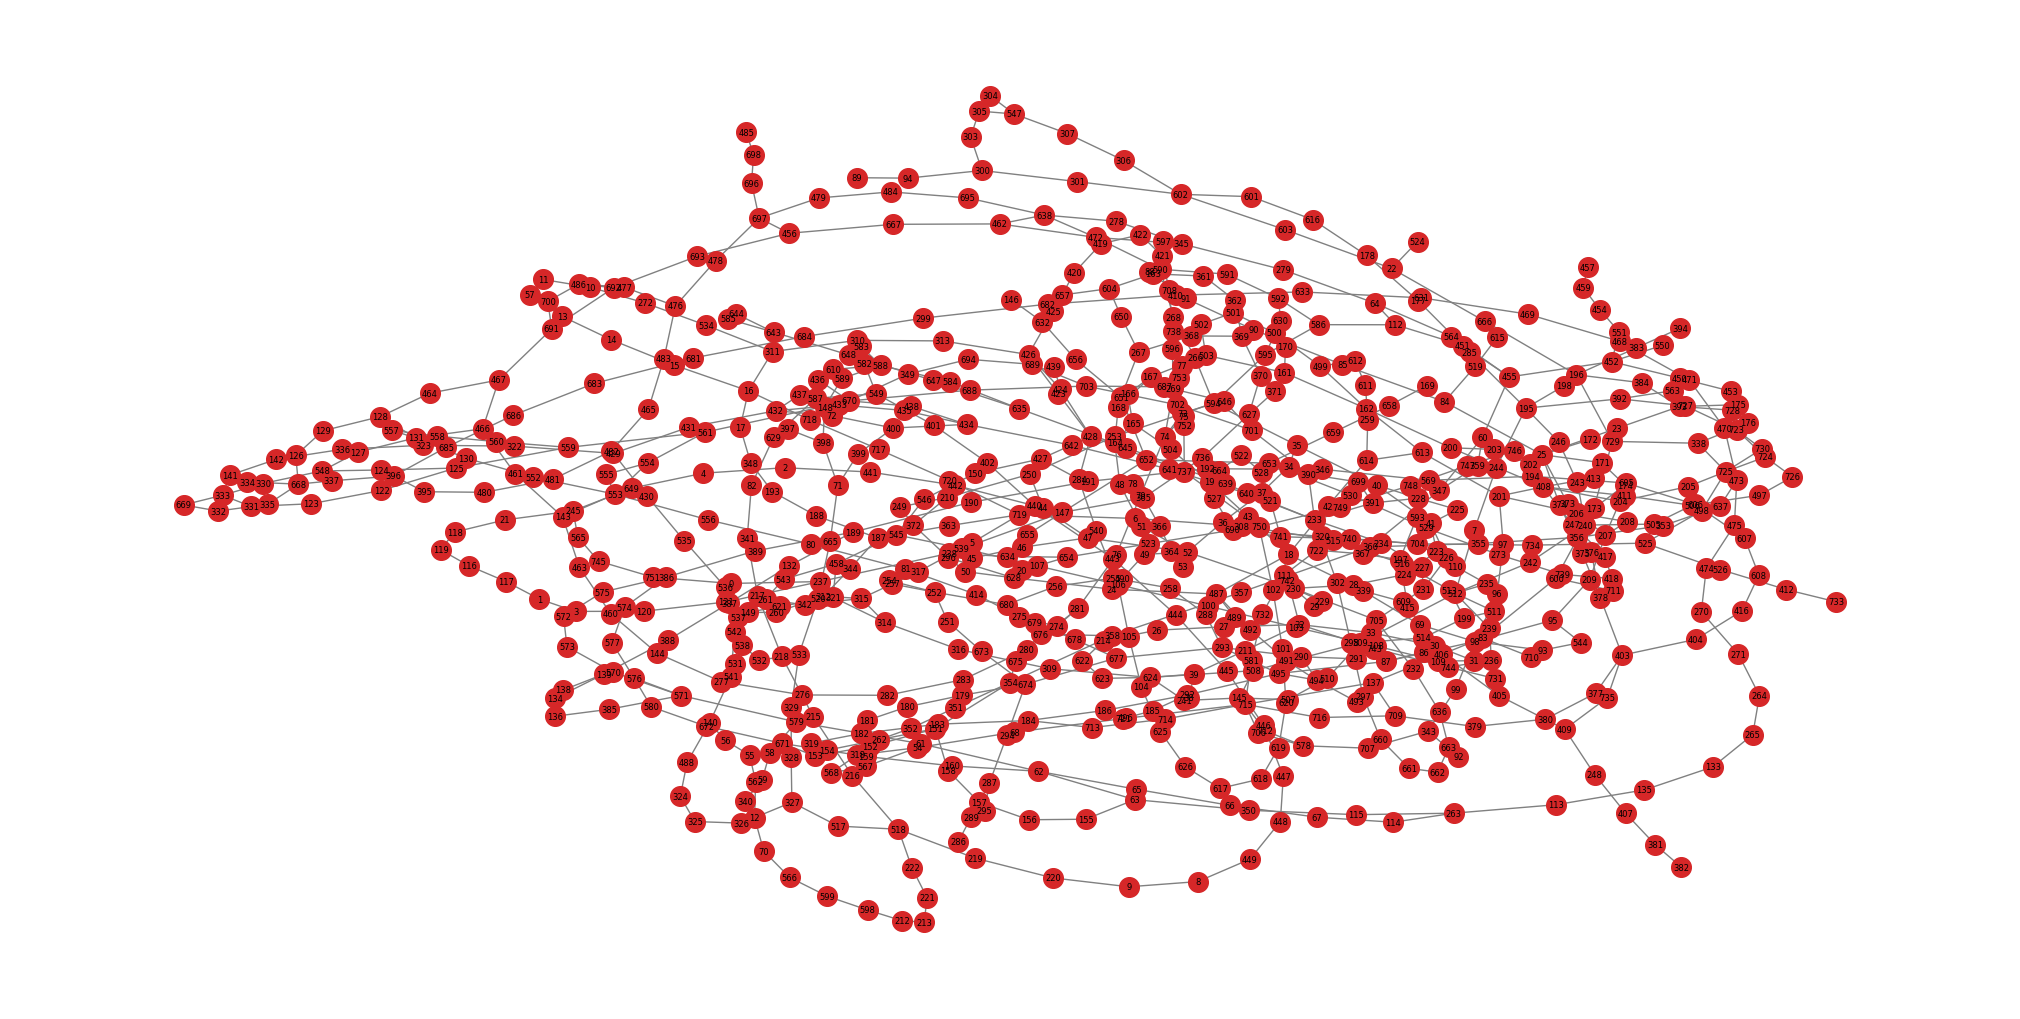

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=200, with_labels=True, font_size=6)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: WM


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df32 = pd.DataFrame(dados, columns=colunas, index=indices)
df32['rede'] = df32.index
df32['tipo'] = 'Tecnológica'
df32['nome_rede'] = 'Kdl'
df32

k1         k2   variance  av_clustering     av_spl  \
Rede original  2.374005   6.344828   0.708926       0.028338  22.726544   
ER             2.698315   9.237366   1.956460       0.000562   7.024507   
WS             2.000000   4.180371   0.180371       0.000000  57.214202   
BA             1.997347  17.458886  13.469489       0.000000   6.123798   
WM             6.050532  44.127660   7.518723       0.020010   3.988395   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.104620    2.672626      0.032064        58   
ER                 -0.018418    3.423383      0.001405        15   
WS                 -0.065765    2.090186      0.000000       135   
BA                 -0.121895    8.741036      0.000000        16   
WM                  0.027567    7.293187      0.017811         8   

                        rede         tipo nome_rede  
Rede original  Rede original  Tecnológica       Kdl  
ER                        ER  Tecnológica       Kdl  
WS                        WS  Tecnológica       Kdl  
BA                        BA  Tecnológica       Kdl  
WM                        WM  Tecnológica       Kdl

#### PCA

# Tabela com as métricas das redes


<ipython-input-4-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1         k2   variance  av_clustering     av_spl  \
Rede original  2.374005   6.344828   0.708926       0.028338  22.726544   
ER             2.698315   9.237366   1.956460       0.000562   7.024507   
WS             2.000000   4.180371   0.180371       0.000000  57.214202   
BA             1.997347  17.458886  13.469489       0.000000   6.123798   
WM             6.050532  44.127660   7.518723       0.020010   3.988395   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.104620    2.672626      0.032064        58   
ER                 -0.018418    3.423383      0.001405        15   
WS                 -0.065765    2.090186      0.000000       135   
BA                 -0.121895    8.741036      0.000000        16   
WM                  0.027567    7.293187      0.017811         8   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             0.882082  0.507403
k2             1.021314  0.167327
variance       0.759799 -0.706675
av_clustering  0.315244  0.944383
av_spl        -0.958476  0.153558
assortativity  0.546139  0.427768
complexity     0.907677 -0.548954
transitivity   0.203245  0.933509
diameter      -0.966961  0.162510

# Gráfico do PCA


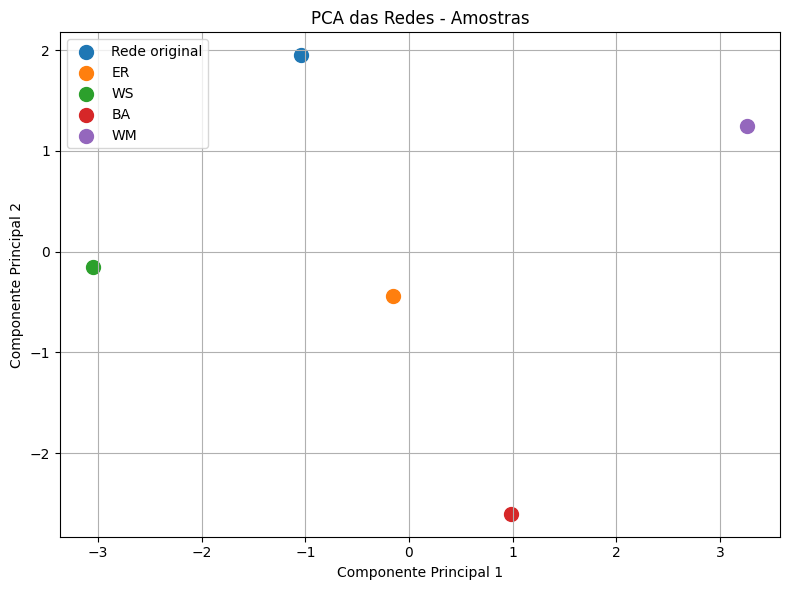

In [ ]:
pca_(G)

Na classificação obtemos que o melhor modelo seria o Waxman (WM), porém, de acordo com o PCA e o gráfico, temos que o modelo ER seria uma melhor classificação.

### Rede Tecnológica 3: Route Views AS graphs

* Um dos 733 snapshots diários de rede que representam o tráfego BGP entre sistemas autônomos (ASs) na Internet, do Oregon Route Views Project, abrangendo o período de 8 de novembro de 1997 a 2 de janeiro de 2000.
* Fonte: https://networks.skewed.de/net/route_views


In [ ]:
g = gt.collection.ns["route_views/19971108"]

In [ ]:
# CONVERSÃO: graph-tool -> NetworkX

g_nx = nx.Graph()

for v in g.vertices():
    g_nx.add_node(int(v))

for e in g.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))

G = g_nx

In [ ]:
# Para tranformar a rede em sem direção. Porém, como a rede já é não direcionada, o código não é necessário.
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

# Para selecionar o maior componente conectado
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0]).copy()

# Vamos verificar o número de vértices (nodes) e arestas (edges)
N = len(G)
M = G.number_of_edges()

print('Número de nós (vértices):', N)
print('Número de arestas:', M)

Número de nós (vértices): 3015
Número de arestas: 5156


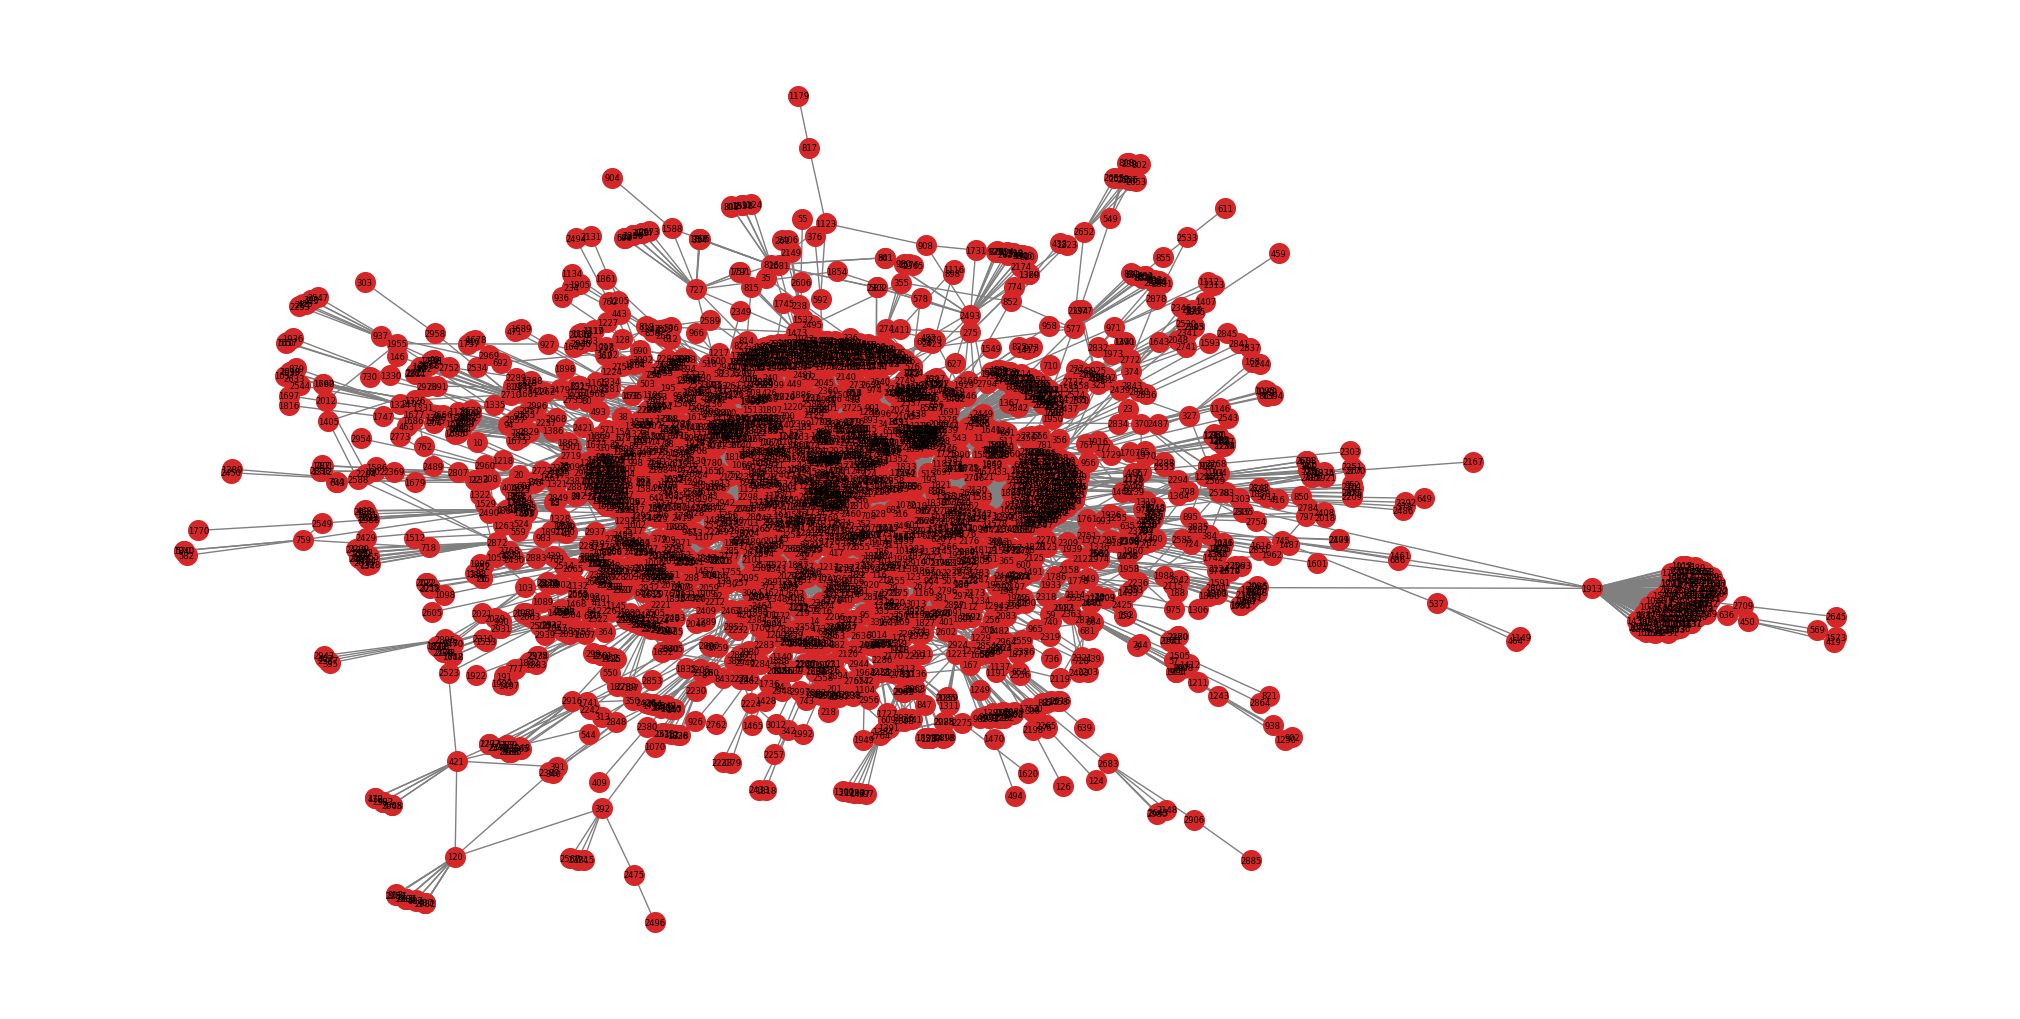

In [ ]:
# Transformando os labels para números inteiros, começando com 0
G = nx.convert_node_labels_to_integers(G, first_label=0)

# Para visualizar a rede
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed = 11) # Definindo uma seed para sempre obter o mesmo gráfico (mesmas posições)
nx.draw(G, pos, node_color='tab:red', edge_color = 'gray', node_size=200, with_labels=True, font_size=6)
plt.show()

#### Classificação

In [ ]:
classe, X_net, x1, x2, x3, x4 = classificacao(G)
print('Classe:', classe)

Classe: WM


<ipython-input-19-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


In [ ]:
# Junta as listas em uma lista de listas
dados = [X_net, x1, x2, x3, x4]

# Define os nomes das redes como índices
indices = ['Rede original', 'ER', 'WS', 'BA', 'WM']

# Define os nomes das colunas
colunas = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
           'complexity', 'transitivity', 'diameter']

# Cria o DataFrame
df33 = pd.DataFrame(dados, columns=colunas, index=indices)
df33['rede'] = df33.index
df33['tipo'] = 'Tecnológica'
df33['nome_rede'] = 'Route'
df33

k1          k2    variance  av_clustering      av_spl  \
Rede original   3.420232  314.680597  302.982609       0.181547    3.761538   
ER              3.471240   14.930007    2.880497       0.001504    6.721292   
WS              2.000000    4.190117    0.190117       0.000000  151.747163   
BA              1.999337   20.498839   16.501492       0.000000    7.497535   
WM             25.345274  700.841128   58.458232       0.020900    2.907512   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.228919   92.005625      0.014903         9   
ER                 -0.022221    4.301058      0.001814        14   
WS                 -0.041084    2.095058      0.000000       422   
BA                 -0.067696   10.252820      0.000000        19   
WM                  0.225984   27.651748      0.020101         5   

                        rede         tipo nome_rede  
Rede original  Rede original  Tecnológica     Route  
ER                        ER  Tecnológica     Route  
WS                        WS  Tecnológica     Route  
BA                        BA  Tecnológica     Route  
WM                        WM  Tecnológica     Route

#### PCA

# Tabela com as métricas das redes


<ipython-input-3-f39d34acccbe>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return cl[int(y_pred)], X_net, x1, x2, x3, x4


k1          k2    variance  av_clustering      av_spl  \
Rede original   3.420232  314.680597  302.982609       0.181547    3.761538   
ER              3.471240   14.930007    2.880497       0.001504    6.721292   
WS              2.000000    4.190117    0.190117       0.000000  151.747163   
BA              1.999337   20.498839   16.501492       0.000000    7.497535   
WM             25.345274  700.841128   58.458232       0.020900    2.907512   

               assortativity  complexity  transitivity  diameter  \
Rede original      -0.228919   92.005625      0.014903         9   
ER                 -0.022221    4.301058      0.001814        14   
WS                 -0.041084    2.095058      0.000000       422   
BA                 -0.067696   10.252820      0.000000        19   
WM                  0.225984   27.651748      0.020101         5   

                        rede  
Rede original  Rede original  
ER                        ER  
WS                        WS  
BA                        BA  
WM                        WM


# Tabela com as componentes principais
                    PC1       PC2
k1             0.542752  0.953009
k2             0.860688  0.643653
variance       0.912726 -0.614890
av_clustering  0.867143 -0.672449
av_spl        -0.755209 -0.159806
assortativity -0.037467  1.112745
complexity     0.963372 -0.534064
transitivity   1.004881  0.383899
diameter      -0.752268 -0.163291

# Gráfico do PCA


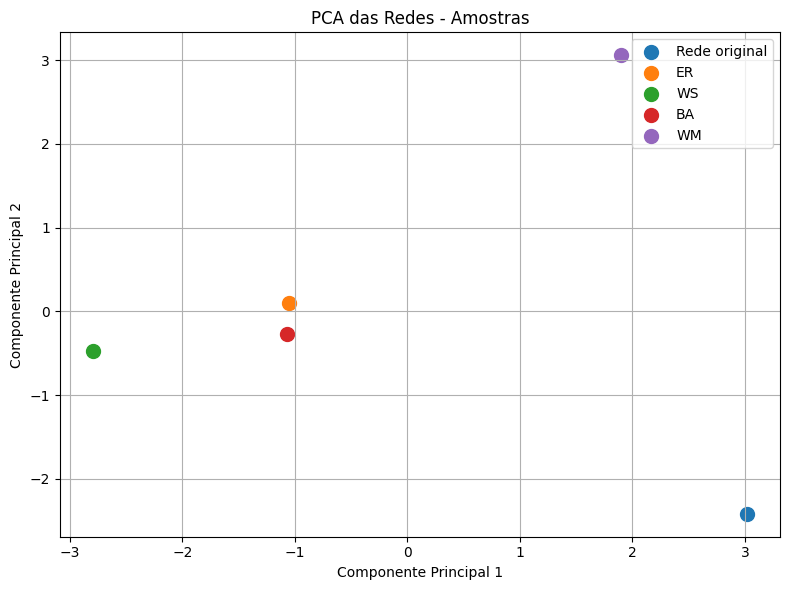

In [ ]:
pca_(G)

Novamente o modelo predito foi o WM. Entretanto, vale notar que os modelos ER e BA aparentam serem modelos satisfatórios para essa rede original.

Portante, temos que no geral, os modelos que mais são adequados para classificar as redes tecnológicas utilizadas são o Erdős–Rényi (ER) e Waxman (WM), diferentemente das redes biológicas e sociais que mais se aproximam do modelo Barabási–Albert (BA).

## **Gráficos com todas as amostras**

Agorra, vamos fazer uma base única contendo todas as redes originais e as geradas e depois aplicar o PCA nesta base.

In [ ]:
df_concat = pd.concat([df11, df12, df13, df21, df22, df23, df31, df32, df33]) # ignore_index=True
df_concat

k1          k2    variance  av_clustering      av_spl  \
Rede original  13.319149  220.936170   43.536442       0.641223    1.850139   
ER             13.361702  188.000000    9.464916       0.284716    1.717854   
WS             12.000000  145.148936    1.148936       0.532550    1.939870   
BA             10.468085  135.829787   26.248981       0.350077    1.834413   
WM              1.000000    1.000000    0.000000       0.000000    1.000000   
Rede original   2.596273   15.254658    8.514023       0.007005    5.326087   
ER              2.612245    8.435374    1.611551       0.018821    5.742335   
WS              2.000000    4.151724    0.151724       0.000000   24.007471   
BA              1.987578   11.925466    7.975001       0.000000    4.948913   
WM              2.000000    4.516129    0.516129       0.032258    6.726882   
Rede original   3.207831   43.286145   32.995963       0.048818    5.200240   
ER              3.333333   13.724359    2.613248       0.005685    5.624300   
WS              2.000000    4.184211    0.184211       0.000000   69.373087   
BA              1.996988   16.590361   12.602401       0.000000    6.026268   
WM              5.418960   36.256881    6.891751       0.022553    4.158286   
Rede original   4.571429   29.657143    8.759184       0.116539    2.705882   
ER              4.685714   24.857143    2.901224       0.104558    2.398319   
WS              4.000000   16.514286    0.514286       0.379048    3.216807   
BA              3.771429   27.085714   12.862041       0.355859    2.299160   
WM              1.333333    2.000000    0.222222       0.000000    1.333333   
Rede original   4.500000   27.500000    7.250000       0.000000    2.758985   
ER              4.093023   19.302326    2.549486       0.076412    2.739756   
WS              4.000000   16.363636    0.363636       0.336364    3.684989   
BA              3.818182   28.409091   13.830579       0.301538    2.434461   
WM              1.500000    2.500000    0.250000       0.000000    1.666667   
Rede original   5.172414   45.655172   18.901308       0.472010    2.152709   
ER              4.689655   24.758621    2.765755       0.167542    2.206897   
WS              4.000000   16.413793    0.413793       0.466667    3.411330   
BA              3.724138   26.689655   12.820452       0.316295    2.137931   
WM              1.333333    2.000000    0.222222       0.000000    1.333333   
Rede original   2.835821    9.850746    1.808866       0.081450    5.231569   
ER              2.807018    9.508772    1.629424       0.028070    4.103383   
WS              2.000000    4.208955    0.208955       0.000000   12.361827   
BA              1.970149   10.059701    6.178213       0.000000    4.113071   
WM              1.666667    3.333333    0.555556       0.000000    2.066667   
Rede original   2.374005    6.344828    0.708926       0.028338   22.726544   
ER              2.698315    9.237366    1.956460       0.000562    7.024507   
WS              2.000000    4.180371    0.180371       0.000000   57.214202   
BA              1.997347   17.458886   13.469489       0.000000    6.123798   
WM              6.050532   44.127660    7.518723       0.020010    3.988395   
Rede original   3.420232  314.680597  302.982609       0.181547    3.761538   
ER              3.471240   14.930007    2.880497       0.001504    6.721292   
WS              2.000000    4.190117    0.190117       0.000000  151.747163   
BA              1.999337   20.498839   16.501492       0.000000    7.497535   
WM             25.345274  700.841128   58.458232       0.020900    2.907512   

               assortativity  complexity  transitivity  diameter  \
Rede original       0.005630   16.587859      0.547243         4   
ER                  0.004668   14.070064      0.285819         3   
WS                 -0.054712   12.095745      0.524449         3   
BA                 -0.162147   12.975610      0.297352         3   
WM                  0.000000    1.000000      0

In [ ]:
# Normalizando os dados
features = ['k1', 'k2', 'variance', 'av_clustering', 'av_spl', 'assortativity',
            'complexity', 'transitivity', 'diameter']
X = df_concat[features]
X = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)
df_concat_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])

# Adiciona colunas ao DataFrame
df_concat_pca['rede'] = df_concat['rede'].values
df_concat_pca['tipo'] = df_concat['tipo'].values
df_concat_pca['rede_original'] = df_concat['nome_rede'].values

# Plot com Plotly
fig = px.scatter(
    df_concat_pca,
    x='PC1',
    y='PC2',
    color='rede_original',
    symbol='tipo',
    text='rede',  # Nome da rede como texto
    labels={'PC1': 'Componente Principal 1', 'PC2': 'Componente Principal 2'},
    title='PCA das Redes: Cor = rede original e modelos, Símbolo = tipo'
)

# Ajustes para melhor visualização
fig.update_traces(textposition='top center', marker=dict(size=12, line=dict(width=1, color='black')))
fig.update_layout(
    legend_title_text='Legenda',
    width=1200,
    height=800
)

fig.show()

O gráfico acima reúne todas as redes originais, juntamente com as redes geradas pelos modelos ER, BA, WS e WM. Ele é interativo, permitindo selecionar uma ou mais redes originais para visualizar a posição do ponto correspondente a elas e às suas respectivas redes geradas. Por exemplo, ao selecionar a rede original *Macaque*, é possível visualizar tanto sua localização no gráfico quanto a das redes geradas especificamente a partir dela.

Ainda sobre este mesmo gráfico, vale comentar que não é possível identificar um padrão claro em que redes do mesmo tipo estejam agrupadas e separadas das redes de outros tipos. O mesmo vale para as redes geradas: aquelas produzidas por um mesmo modelo não formam grupos e nem se distanciam significativamente das redes geradas por outros modelos.

---

A seguir, é apresentado um gráfico (gerada a partir do gráfico interativo mostrado anteriormente) contendo somente as redes biológicas originais e suas respectivas redes geradas.

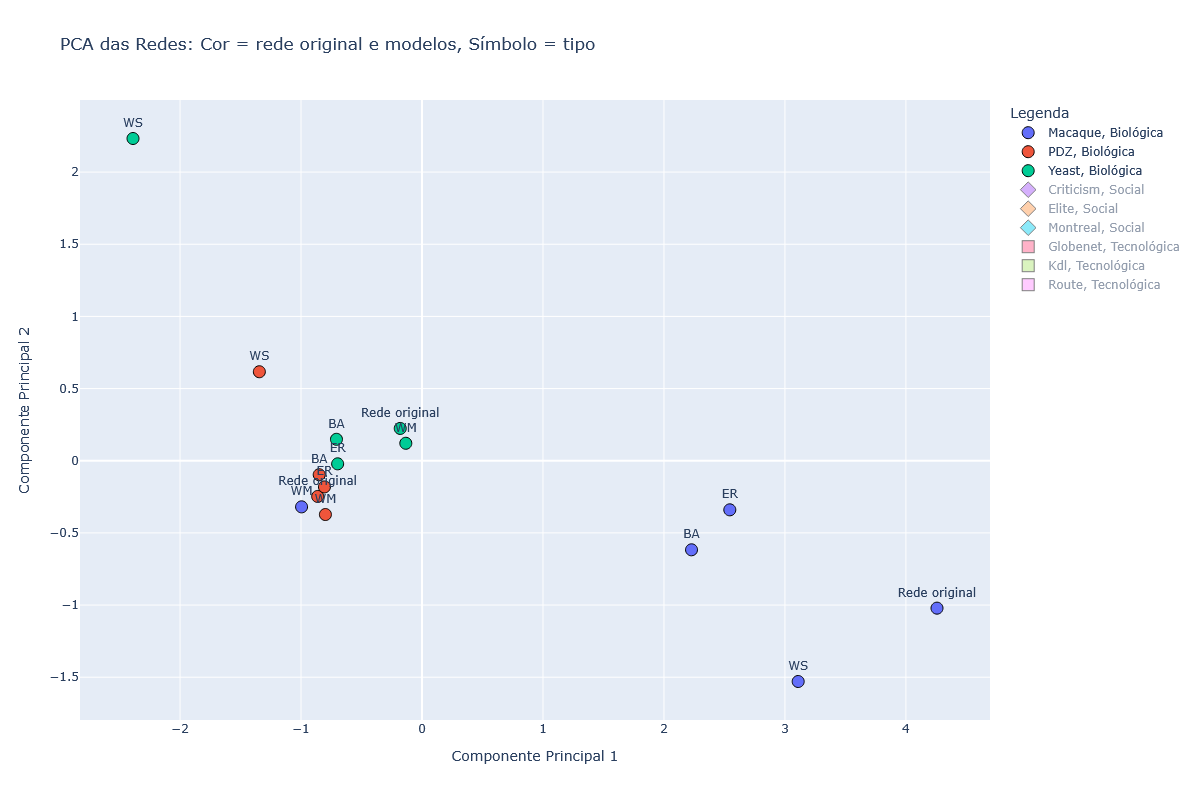

A seguir, um gráfico contendo somente as redes sociais originais e suas respectivas redes geradas.

É interessante observar que as redes geradas por um mesmo modelo aparecem agrupadas, ou seja, redes geradas pelo modelo ER, por exemplo, estão concentradas significativamente.

Obs.: Vale notar que as redes geradas com o modelo WM para as redes *Criticism* e *Montreal* foram iguais, o que justifica não estarmos vendo claramente 3 pontos para o modelo WM.

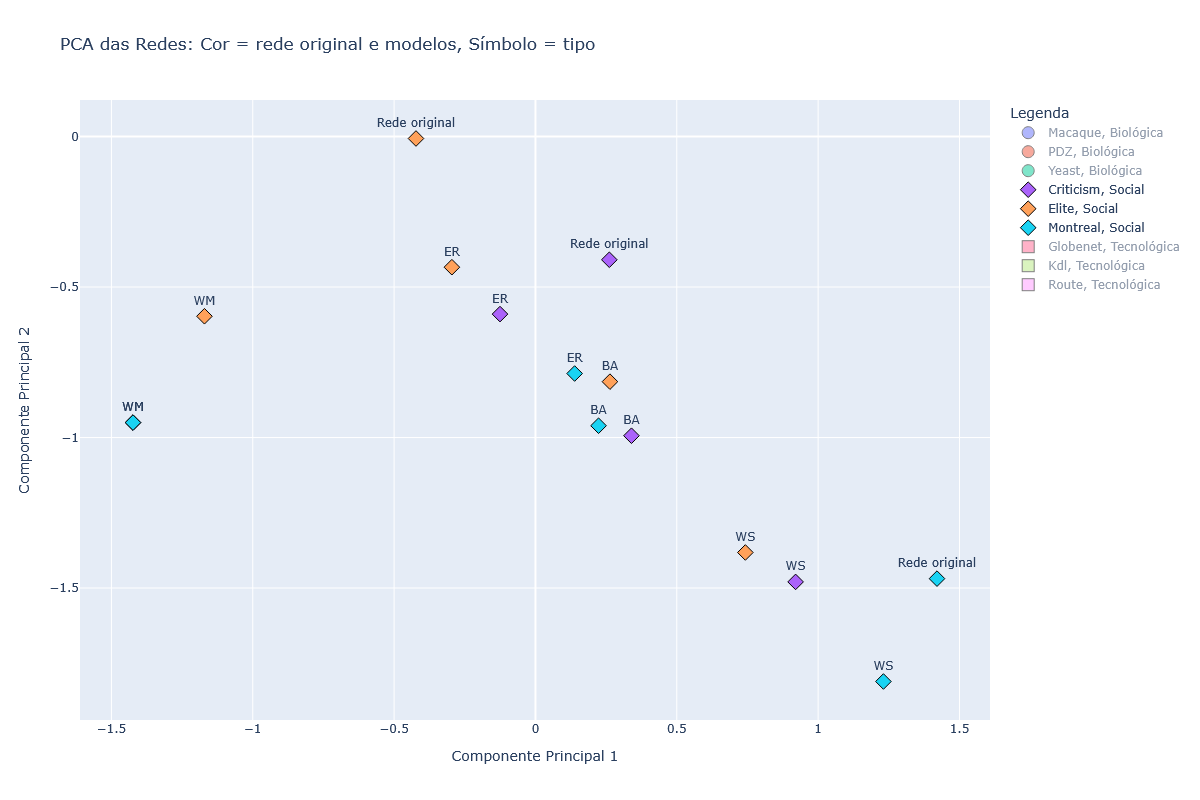

Por fim, um gráfico apenas com as rede tecnológicas originais e suas respectivas redes geradas.

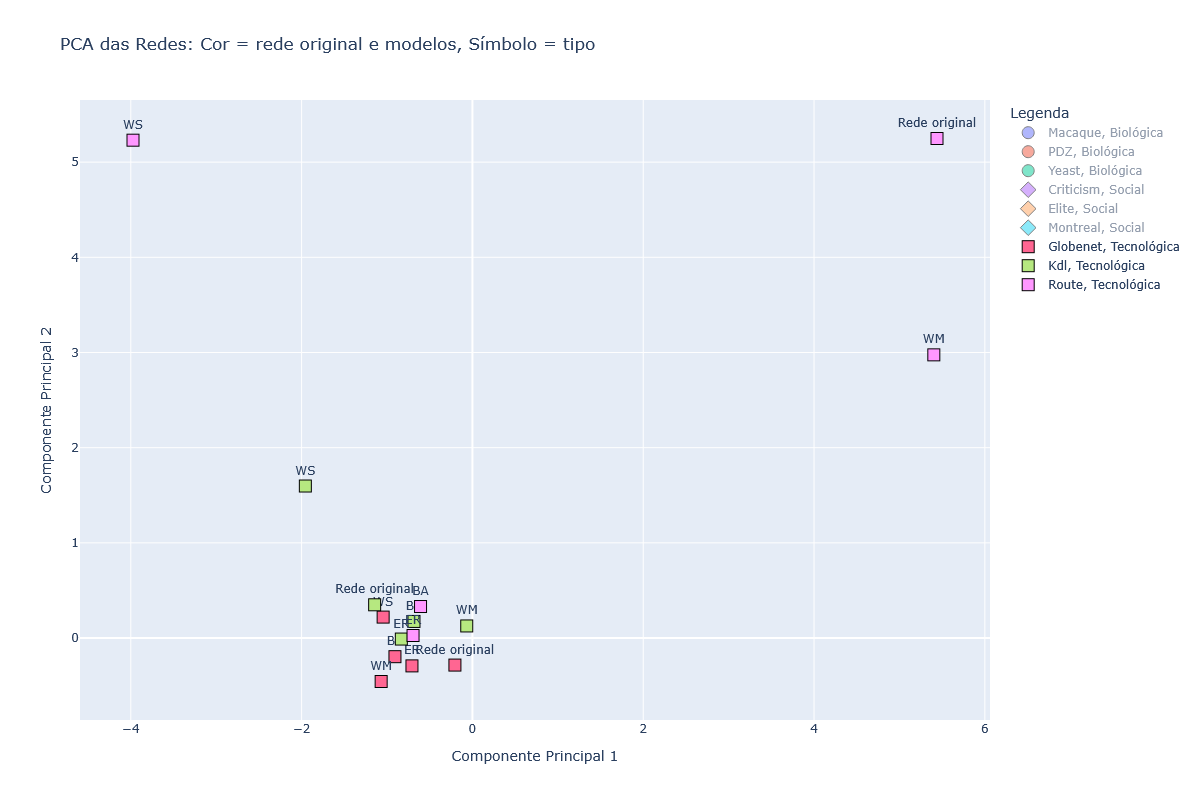

# **Conclusão**

Neste projeto, foi possível verificar como é feita a classificação de redes complexas a partir de modelos geradores. Foram utilizadas diferentes métricas estruturais para caracterizar as redes, e a técnica de classificação via KNN mostrou-se eficaz na maioria dos casos. No geral, os resultados obtidos com a classificação foram coerentes com o que foi observado nos gráficos de PCA, indicando que a abordagem adotada é válida e satisfatoria.